In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
plt.rcParams["figure.figsize"] = (15,7)
from scipy.stats import shapiro
from statsmodels.tsa.api import VAR
import seaborn as sns
import os
import tensorflow as tf
import random
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras_self_attention import SeqSelfAttention
import keras
import warnings
warnings.filterwarnings("ignore")
from pandas_datareader.data import DataReader
import pandas as pd
from pandas import DataFrame
from datetime import datetime,timedelta
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Stock Forecasting for week ahead for Banks.
 
For this analysis the data for 12 banks is chosen.



## Banks vs famous tech companies

- One of the key features of the stock data for banks is that it is not very smooth. 
- Unlike the stock data for many tech companies, the time series stock data for bank has many fluctuations which make it a bit more challenging to forecast the stock price for banks.

### For reference below is the plot of two tech companies Amazon and Google which follow a general upward trend with lesser fluctuations this is in contrast with the time series of two famous banks Scotiabank and Royal Bank of Canada which follow a trend similar to each other but different from the tech companies.

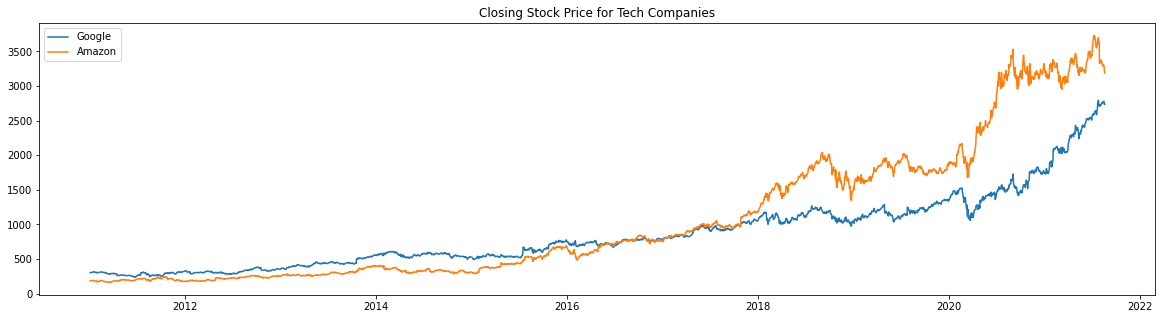

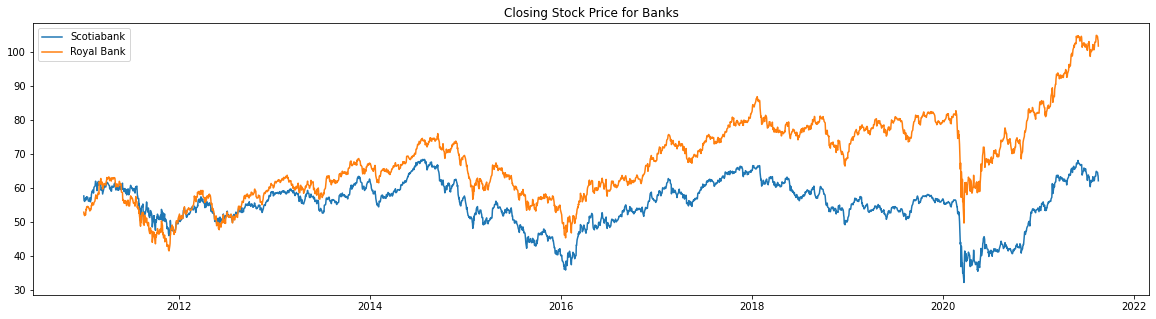

In [85]:
plt.plot(DataReader("GOOG", data_source='yahoo', start='2011-01-01', end=datetime.now())["Close"],label="Google")
plt.plot(DataReader("AMZN", data_source='yahoo', start='2011-01-01', end=datetime.now())["Close"],label="Amazon")
plt.legend()
plt.title("Closing Stock Price for Tech Companies")
plt.show()
plt.plot(DataReader("BNS", data_source='yahoo', start='2011-01-01', end=datetime.now())["Close"],label="Scotiabank")
plt.plot(DataReader("RY", data_source='yahoo', start='2011-01-01', end=datetime.now())["Close"],label="Royal Bank")
plt.title("Closing Stock Price for Banks")
plt.legend()


# Proposed Approach:

### The stock price for the future Thursday is forecasted using the following four forecasting models. The final stock price reported is the voting regressor ensemble value from all the four model outputs.

## 1.[ Approach 1: Statistical Method 1: Multivariate forecasting considering the closing data from all considered banks](#stat1)
#### In this approach the data from all banks (which have high correlation with each other) is used for multivariate forecasting by fitting a VAR (Vector Autoregressive Model) to it. In most of the approches for forecasting the stocks the time series from other organizations are not considered at all. It is important to consider the time series from other organizations as they might have an impact on each other indirectly in the stock market. 

## 2. [Approach 2: Univariate forecast using Gated Recurrent Unit](#dl1)
#### In this approach the past 20 days (4 weeks) closing price is fed into the DL model to forecast the closing price for 5 days ahead. This is done for all the banks using separate models for each.
## 3. [Approach 3: Statistical Method 2: Multivariate forecasting considering the open, close, low, high, volume stock price](#stat2)
#### In this method all the price features are fed into the VAR statistical model to get a multivariate forecast for 5 days ahead.
## 4. [Approach 4: News Sentiment Anlysis for Stock Price Prediction: Forecasting the close price using the derived sentiments from news and historical close prices.](#dl2)
#### In this method the Sentiments from the news and historical closing prices for past 25 days are fed into the DL model for 5 days ahead forecast.

### Note: All the above models are tested and fine-tuned in separate python notebooks in the submission folder.

## The final output is derived from the [Voting Regressor Ensemble](#vr) taken over the outputs from the all the four models proposed above. The ensemble is performed in a weighted manner according to the errors  obtained from the models. The higher the error of model the lesser is the weight and vice versa.

## The block diagram below explains the outiline of the experiment.

<img src="Stockblock.jpg">


## [Result:](#vr) The final result, conclusion and future work are stated here under this section

# Data Description:

Stock data for banks from US and Canada are chosen for this work.

Following banks are chosen for forecasting with their corresponding tickers/symbols stated below:

Name of Bank | Ticker Symbol|
--- | --- | 
Scotiabank | BNS | 
Royal Bank of Canada  | RY | 
TD (Toronto Dominion Bank)| TD| 
Bank of Montreal | BMO | 
Canadian Imperial Bank (CIBC) | CM |
Citi Bank| C |
JP Morgan Bank | JPM |
ICICI Bank | IBN |
West Bancorporation | WTBA | 
Bank of America | BAC |
American Express | AXP |
PNC Financial Services | PNC |

##### Note: The stock data from year 2011 to current date is taken from yahoo finance source.


Below is the created dataframe for the closig prices of all the considered banks from 2011 to the current date (19th August, 2021).


In [89]:
tickers=['BNS', 'RY', 'TD','BMO','CM','C','JPM','IBN', 'WTBA','BAC','AXP','PNC']
m_df=pd.DataFrame()
for item in tickers:
    df = DataReader(item, data_source='yahoo', start='2011-01-01', end=datetime.now())
    m_df[item]=df["Close"]
m_df.head()

BNS         RY         TD        BMO         CM          C  \
Date                                                                           
2011-01-03  57.570000  52.799999  37.555000  58.230000  78.760002  49.000000   
2011-01-04  56.310001  52.270000  37.044998  57.660000  77.980003  49.000000   
2011-01-05  56.250000  52.290001  37.139999  57.889999  78.040001  49.700001   
2011-01-06  55.959999  51.790001  37.009998  58.389999  77.349998  49.500000   
2011-01-07  56.689999  52.389999  37.380001  58.720001  77.900002  49.400002   

                  JPM       IBN  WTBA    BAC        AXP        PNC  
Date                                                                
2011-01-03  43.580002  9.290909  7.96  14.19  43.400002  61.459999  
2011-01-04  44.160000  8.783636  7.78  14.24  43.950001  60.630001  
2011-01-05  44.700001  8.636364  7.92  14.50  45.040001  61.799999  
2011-01-06  44.480000  8.378182  7.91  14.44  44.730000  62.279999  
2011-01-07  43.639999  8.325455  7.90  14.25  44.360001  61.939999

# Data Visualization

Below are the Histograms and the Boxplots to see whether the time series has a normal distribution or not. A normal distribution suggests that the time series is stationary but we can clearly see from the boxplots that the time series is not stationary and follows some kind of trend.

array([[<AxesSubplot:title={'center':'AXP'}>,
        <AxesSubplot:title={'center':'BAC'}>,
        <AxesSubplot:title={'center':'BMO'}>],
       [<AxesSubplot:title={'center':'BNS'}>,
        <AxesSubplot:title={'center':'C'}>,
        <AxesSubplot:title={'center':'CM'}>],
       [<AxesSubplot:title={'center':'IBN'}>,
        <AxesSubplot:title={'center':'JPM'}>,
        <AxesSubplot:title={'center':'PNC'}>],
       [<AxesSubplot:title={'center':'RY'}>,
        <AxesSubplot:title={'center':'TD'}>,
        <AxesSubplot:title={'center':'WTBA'}>]], dtype=object)

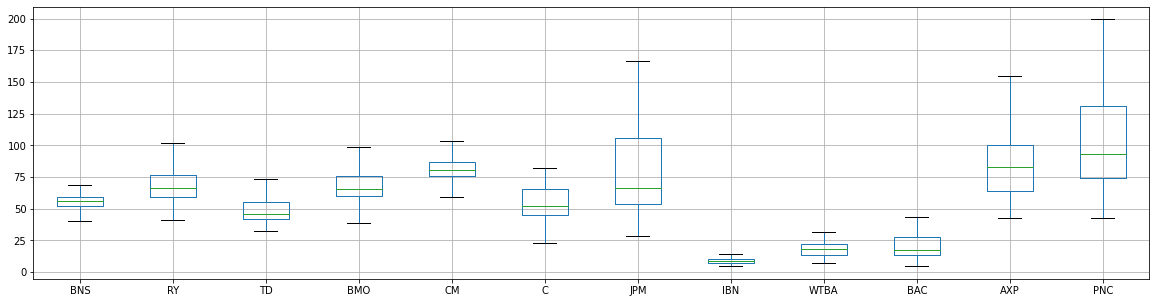

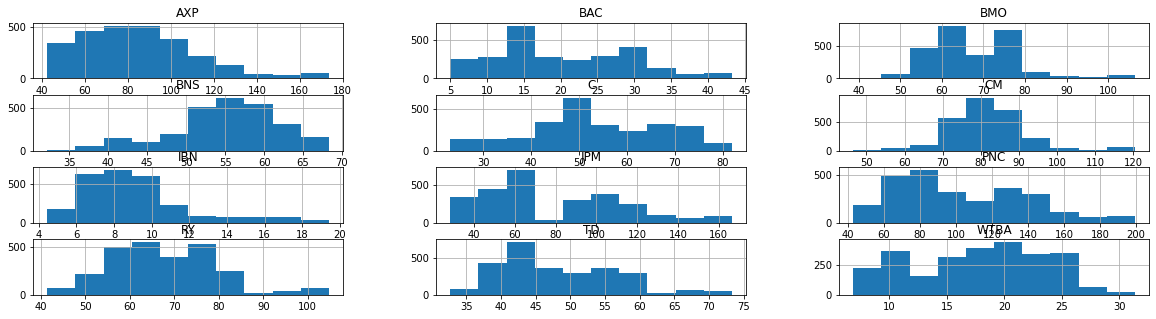

In [90]:
df=m_df
df.boxplot(showfliers=False)
df.hist()

### - The time series for the closing prices for all the banks is plotted below and it observed that all of the time series follow a similar kind of trend and fluctuations which suggestes some kind of correlation.

### - A general upward trend is also observed in majorly all the banks.

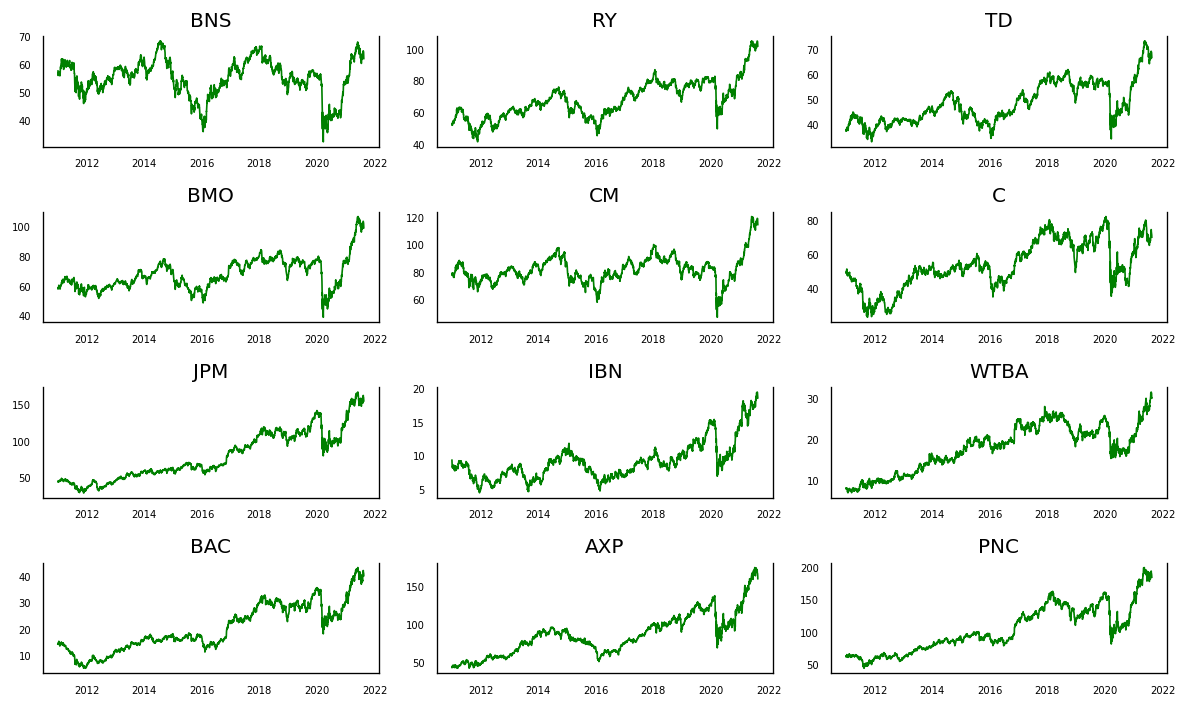

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='g', linewidth=1)
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

### The correlation Matrix suggests some kind of correlation amongst the time series thus we can proceed to feed the correlated set of time series in our statistical model for forecasting.

In [6]:
df.corr()

BNS        RY        TD       BMO        CM         C       JPM  \
BNS   1.000000  0.501694  0.538563  0.701213  0.809743  0.415781  0.176833   
RY    0.501694  1.000000  0.969317  0.912049  0.796404  0.850916  0.903972   
TD    0.538563  0.969317  1.000000  0.938183  0.803606  0.860373  0.894319   
BMO   0.701213  0.912049  0.938183  1.000000  0.919212  0.773447  0.754833   
CM    0.809743  0.796404  0.803606  0.919212  1.000000  0.594061  0.540946   
C     0.415781  0.850916  0.860373  0.773447  0.594061  1.000000  0.860042   
JPM   0.176833  0.903972  0.894319  0.754833  0.540946  0.860042  1.000000   
IBN   0.251514  0.821265  0.764997  0.701057  0.584409  0.659743  0.821160   
WTBA  0.183039  0.776480  0.797048  0.697031  0.483907  0.869983  0.860984   
BAC   0.251562  0.923091  0.914879  0.787042  0.588772  0.906371  0.987102   
AXP   0.251335  0.916941  0.885284  0.777780  0.609946  0.787879  0.914641   
PNC   0.265296  0.909016  0.917359  0.802024  0.599544  0.899031  0.977485   

           IBN      WTBA       BAC       AXP       PNC  
BNS   0.251514  0.183039  0.251562  0.251335  0.265296  
RY    0.821265  0.776480  0.923091  0.916941  0.909016  
TD    0.764997  0.797048  0.914879  0.885284  0.917359  
BMO   0.701057  0.697031  0.787042  0.777780  0.802024  
CM    0.584409  0.483907  0.588772  0.609946  0.599544  
C     0.659743  0.869983  0.906371  0.787879  0.899031  
JPM   0.821160  0.860984  0.987102  0.914641  0.977485  
IBN   1.000000  0.570602  0.800930  0.863010  0.775970  
WTBA  0.570602  1.000000  0.871333  0.753536  0.918466  
BAC   0.800930  0.871333  1.000000  0.911075  0.979460  
AXP   0.863010  0.753536  0.911075  1.000000  0.891922  
PNC   0.775970  0.918466  0.979460  0.891922  1.000000

### The scatter plots between the different time series also suggest some linear correlation.

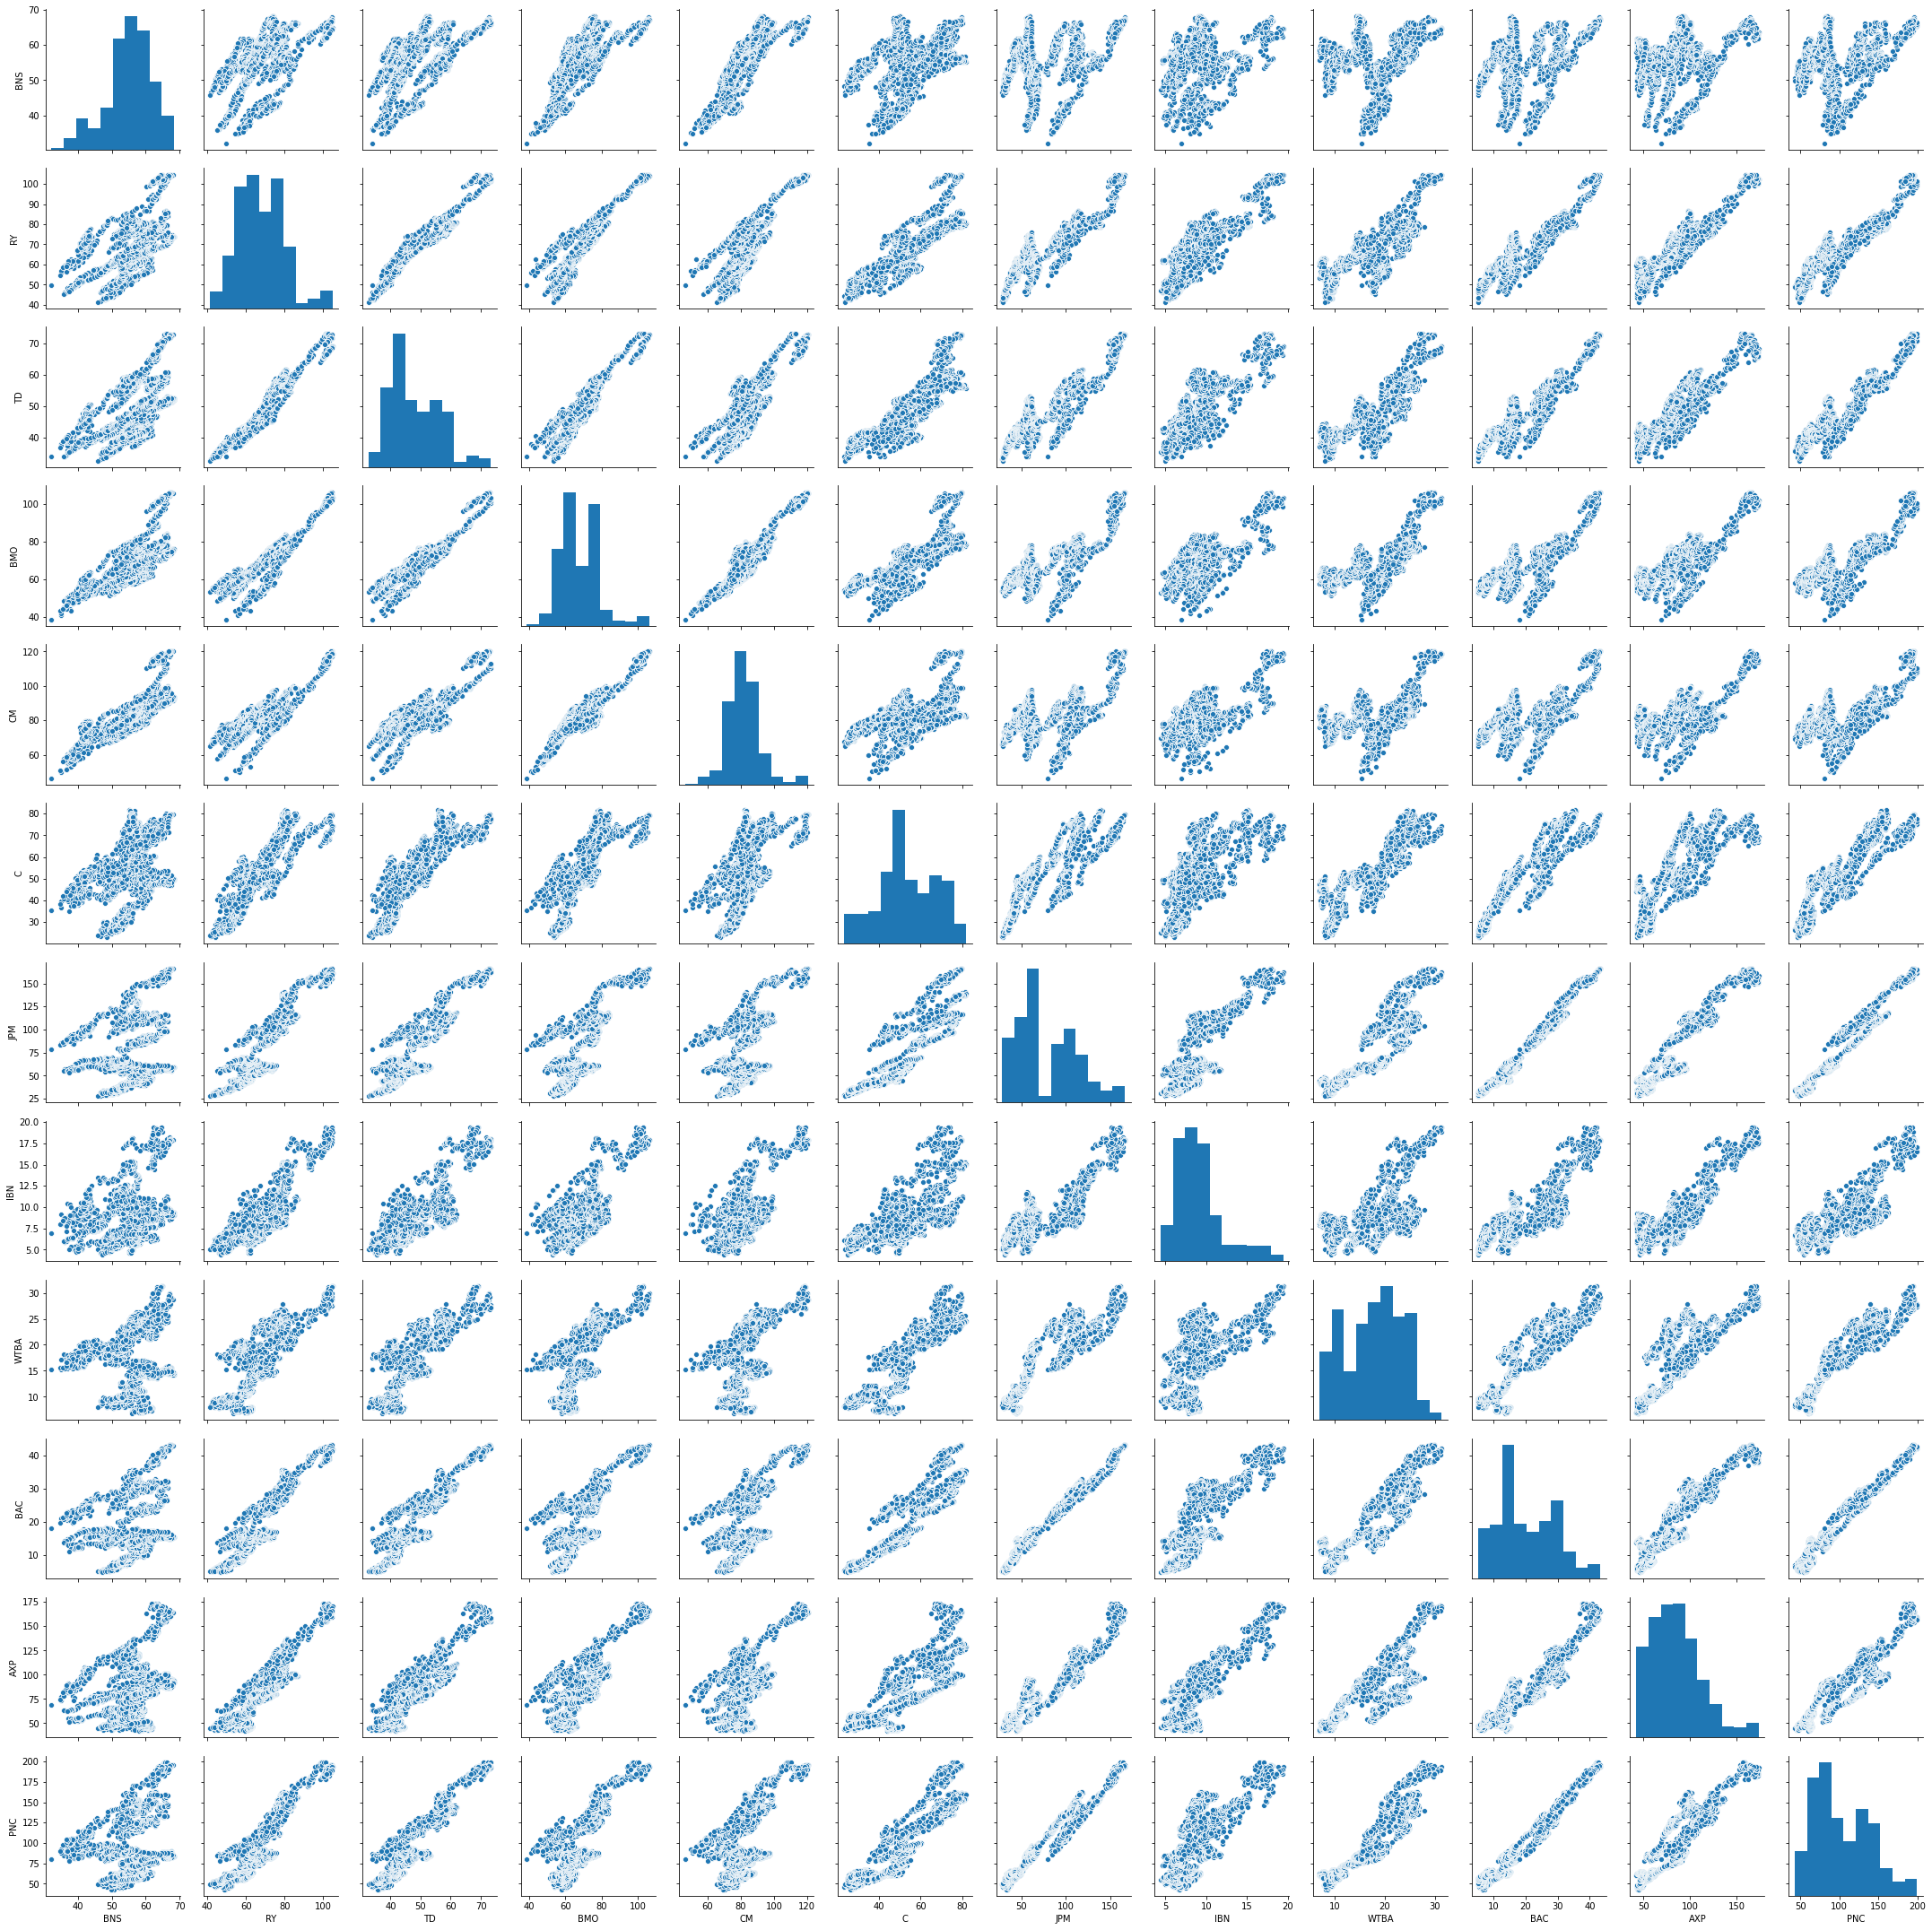

In [98]:
sns.pairplot(df)

<a id="stat1"><a>

# 1. Statistical Method 1: Multivariate forecasting considering the closing data from all considered banks

- In most of the approches for forecasting the stocks the time series from other organizations are not considered at all. It is important to consider the time series from other organizations as they might have an impact on each other indirectly in the stock market. Therfore in this approach we consider the closing price time series from all the 12 banks and feed it to the Vector Autoregressive Statistical Model which is used for themultivariate time series forecasting.

In order to confirm that our is not normally distributed normaltest is performed and since the significance value p is less than 0.05 the null hypotheis is rejected and data is non-Gaussian is further confirmed.

In [95]:
for i in df.columns:
    print("For: ",i)
    stat,p = stats.normaltest(df[i])
    print("Statistics = %.3f, p=%.3f" % (stat,p))
    if p> 0.05:
        print('Data looks Gaussian (fail to reject null hypothesis)')
    else:
        print('Data looks non-Gaussian (reject null hypothesis')

For:  BNS
Statistics = 147.193, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  RY
Statistics = 134.192, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  TD
Statistics = 173.839, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  BMO
Statistics = 316.131, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  CM
Statistics = 382.852, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  C
Statistics = 164.973, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  JPM
Statistics = 218.404, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  IBN
Statistics = 579.935, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  WTBA
Statistics = 571.263, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  BAC
Statistics = 209.344, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  AXP
Statistics = 233.001, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  PNC
Statistics = 191.160, p=0.

### Following are the probablity and distribution plots for each of the time series which furhter confirm that data is not normal and time series is not stationary.

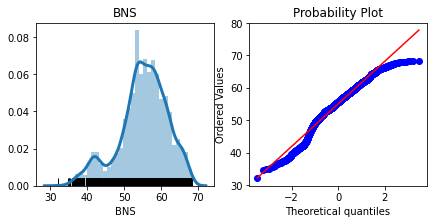

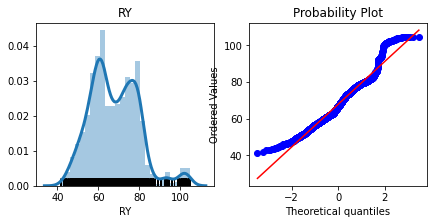

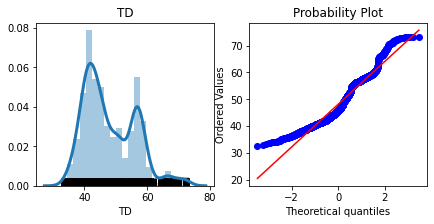

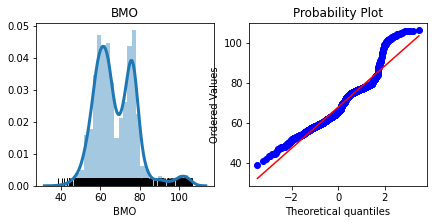

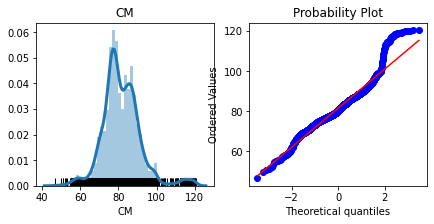

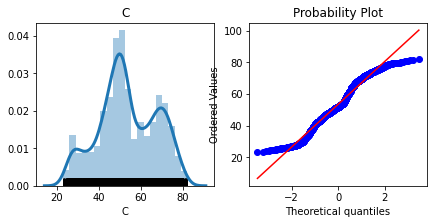

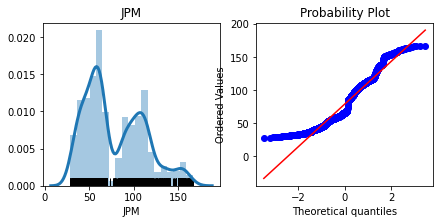

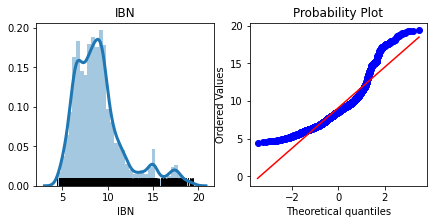

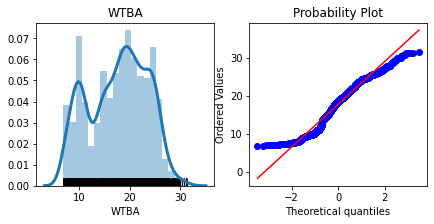

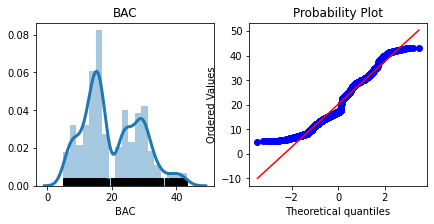

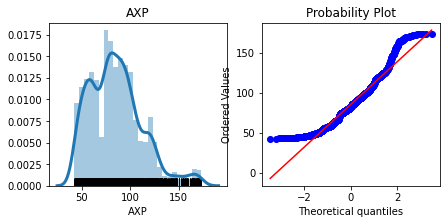

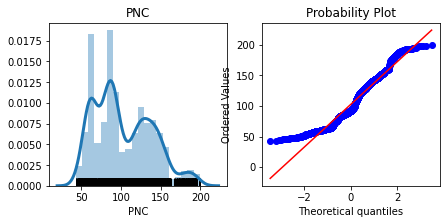

In [99]:
for i in df.columns:
    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1)
    sns.distplot(df[i], hist = True, kde = True, rug = True,
             kde_kws={'linewidth': 3},
             rug_kws={'color': 'black'})
    plt.title(i)
    plt.subplot(1,2,2)
    stats.probplot(df[i], plot=plt);
    df[i].describe().T


## ADF test for stationarity of time series
This is one of the very important test to find whether the time series is stationary or not:

- Null Hypotheiss is that the time series has unit root and is not stationary.

- We find that the TS is not stationary and hence differencing is needed to model it.

Since the significance value of all the time series is more thna 0.05 hence we accept the null hypothesis and consider that they are not stationary.

In [9]:
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
for i in df.columns:
    print('Augmented Dickey-Fuller Test:',i)
    augmented_dickey_fuller_statistics(df[i])

Augmented Dickey-Fuller Test: BNS
ADF Statistic: -2.659531
p-value: 0.081307
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Augmented Dickey-Fuller Test: RY
ADF Statistic: -1.022542
p-value: 0.744954
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Augmented Dickey-Fuller Test: TD
ADF Statistic: -1.479319
p-value: 0.543716
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Augmented Dickey-Fuller Test: BMO
ADF Statistic: -1.781521
p-value: 0.389674
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Augmented Dickey-Fuller Test: CM
ADF Statistic: -2.107274
p-value: 0.241600
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Augmented Dickey-Fuller Test: C
ADF Statistic: -2.024827
p-value: 0.275795
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Augmented Dickey-Fuller Test: JPM
ADF Statistic: -0.140688
p-value: 0.945232
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Augmented Dickey-Fuller Test: IBN
ADF Statistic: -0.503371
p-value: 0.891357
Critical Va

## Stationarizing the time series.

In order to apply the statistical models we need to stationarize the time series and for that differnecing is performed.

The distribution of the time series after differencing appears to be normal.

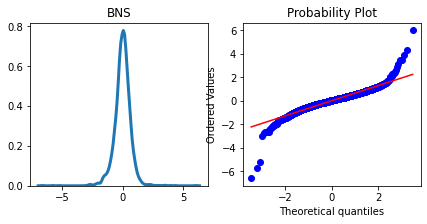

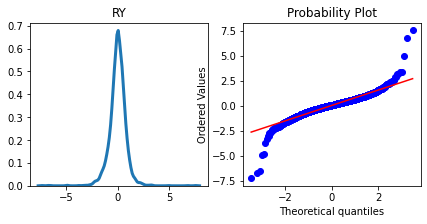

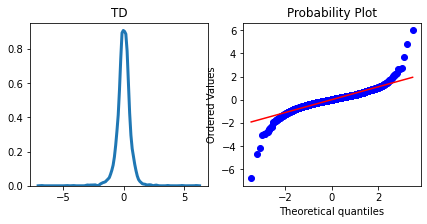

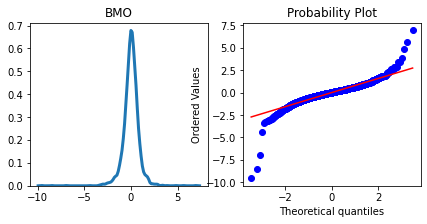

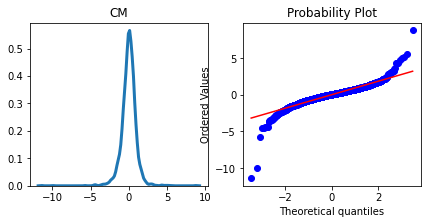

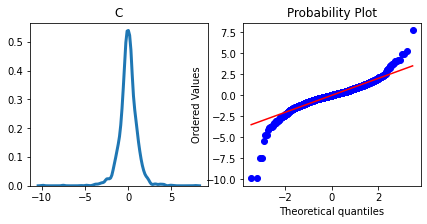

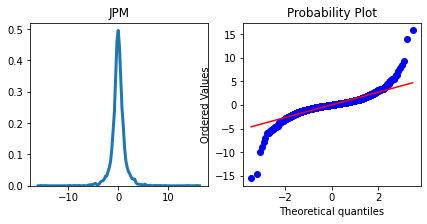

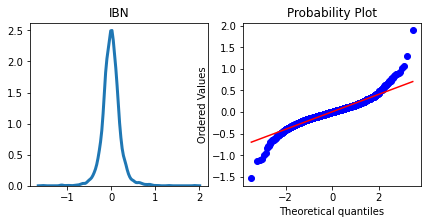

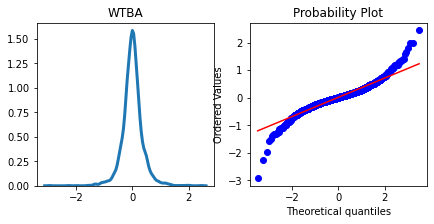

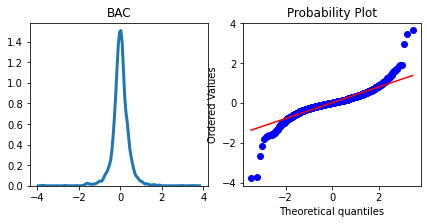

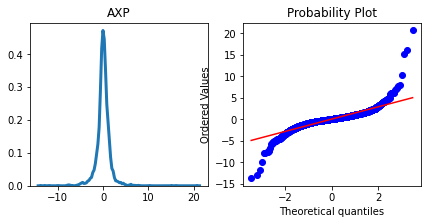

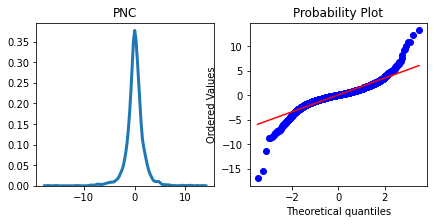

In [10]:
# To perform differencing.
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff
for i in df.columns:
    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1)
    sns.distplot(difference(df[i]), hist = False, kde = True,kde_kws={'linewidth': 3})
    plt.title(i)
    plt.subplot(1,2,2)
    stats.probplot(difference(df[i]), plot=plt);
    df[i].diff().describe().T

## The ADF test now has p value less than 0.05 now and hence we can say time series is stationary.

In [11]:
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
X_diff=df.diff().dropna()        
for i in X_diff.columns:
    print('Augmented Dickey-Fuller Test:',i)
    augmented_dickey_fuller_statistics(X_diff[i])

Augmented Dickey-Fuller Test: BNS
ADF Statistic: -9.863550
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Augmented Dickey-Fuller Test: RY
ADF Statistic: -15.783140
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Augmented Dickey-Fuller Test: TD
ADF Statistic: -9.656369
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Augmented Dickey-Fuller Test: BMO
ADF Statistic: -9.248282
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Augmented Dickey-Fuller Test: CM
ADF Statistic: -9.638634
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Augmented Dickey-Fuller Test: C
ADF Statistic: -10.147136
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Augmented Dickey-Fuller Test: JPM
ADF Statistic: -9.801567
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Augmented Dickey-Fuller Test: IBN
ADF Statistic: -10.353568
p-value: 0.000000
Critical

# Causality of Time Series

### In order to find the lag (lag - how much past affects the future) the ACF (Autocorrelation) and the PACF (Partial Autocorrelation) plots are analyzed.

## Below are the ACF plot for the non-differenced and differenced time series
- It is found that the ACF plots are attenuating suggesting of an Autoregressive Process.

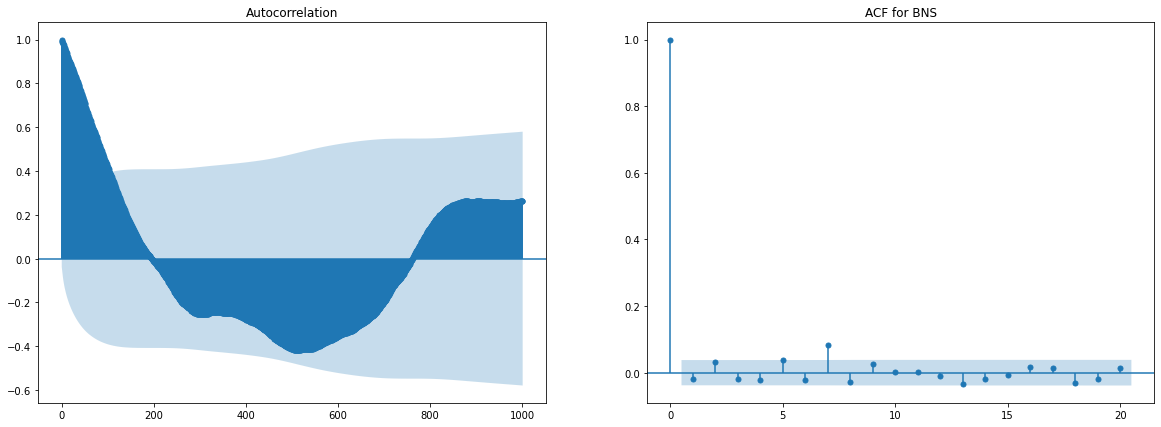

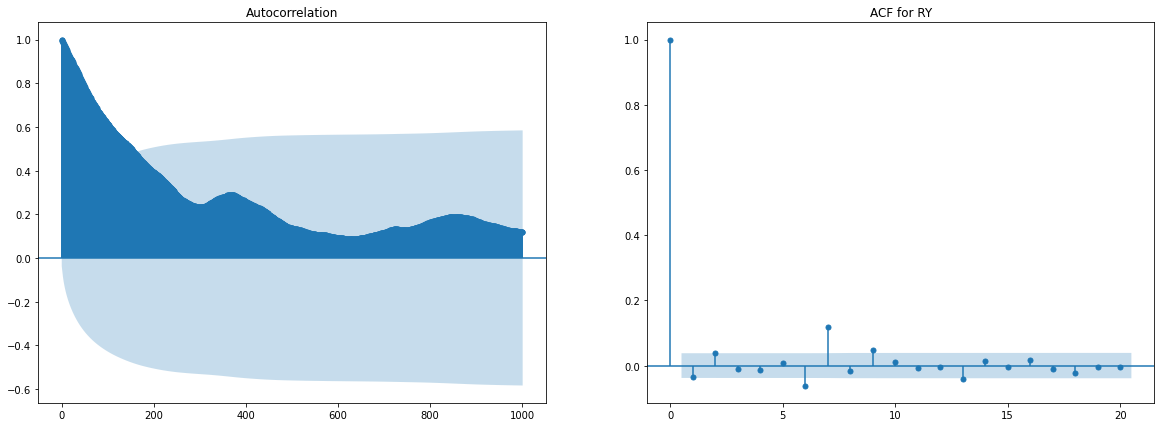

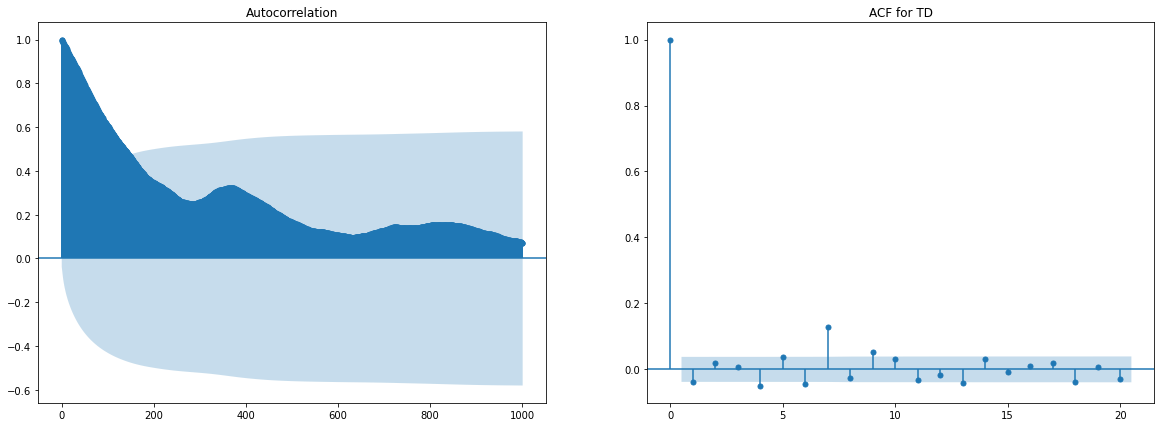

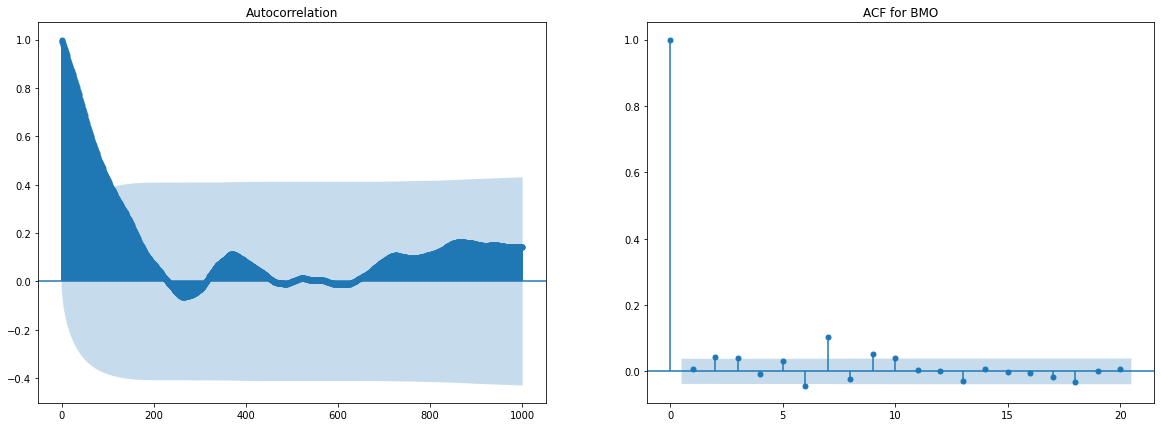

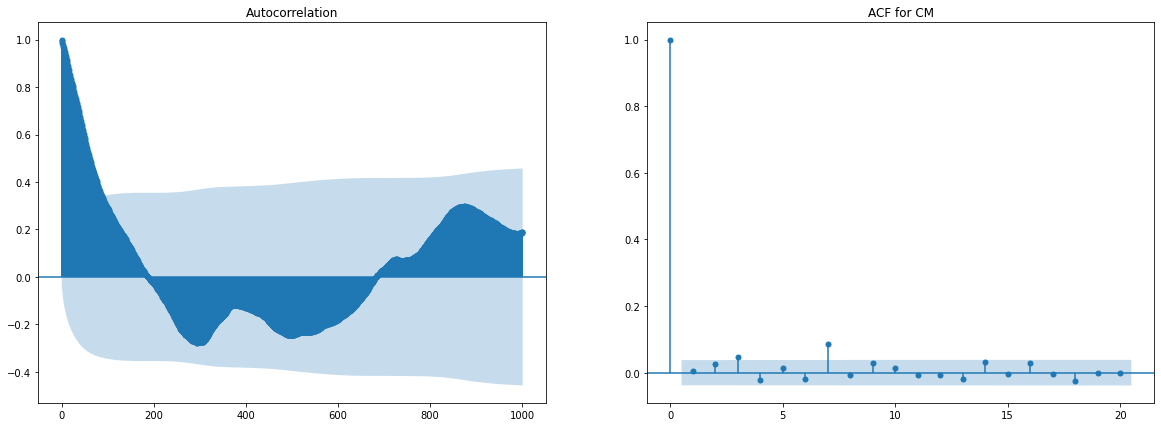

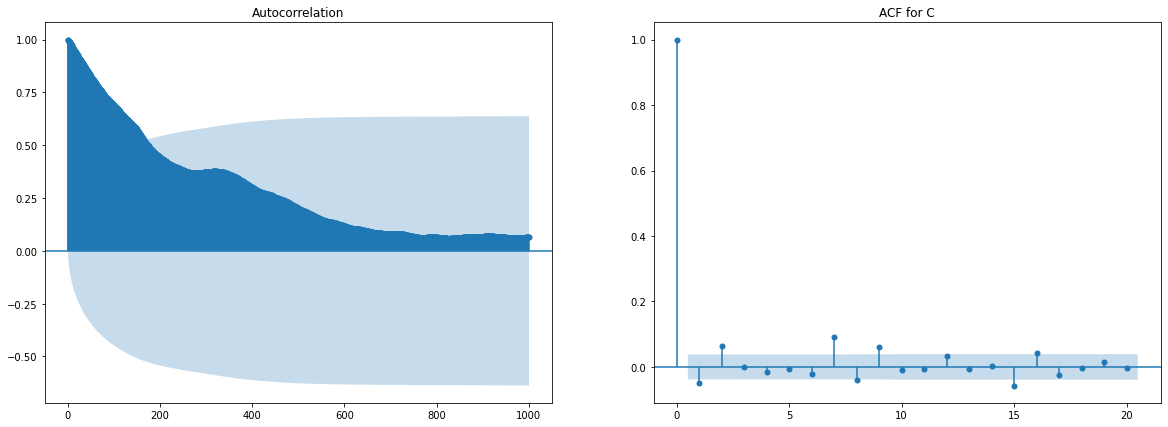

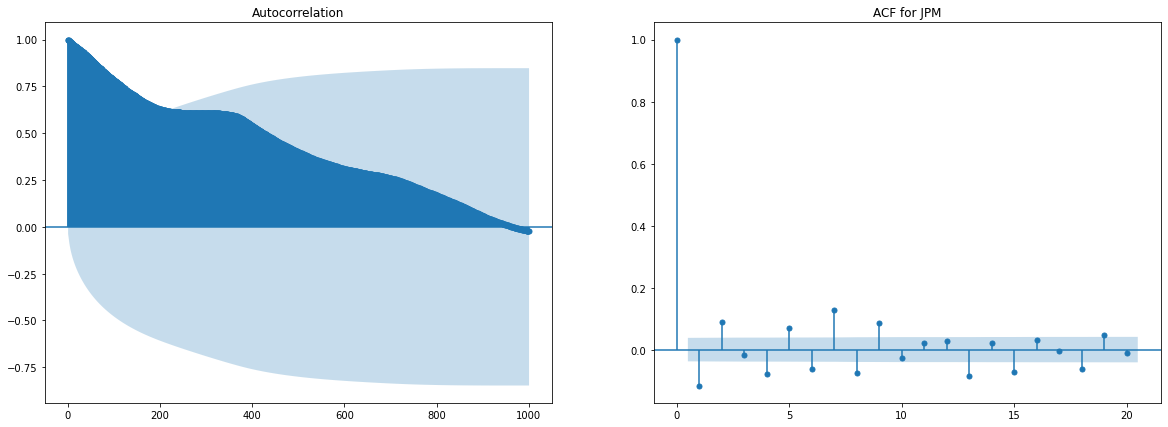

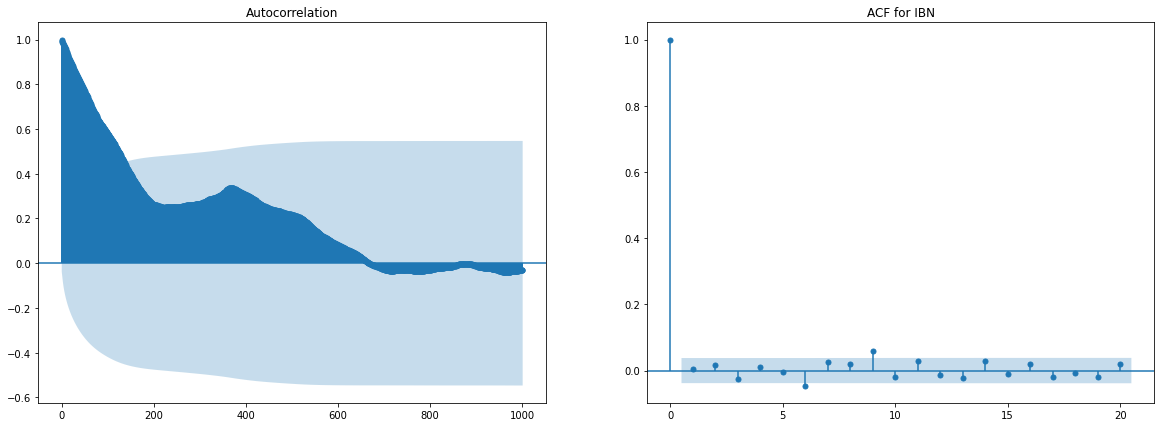

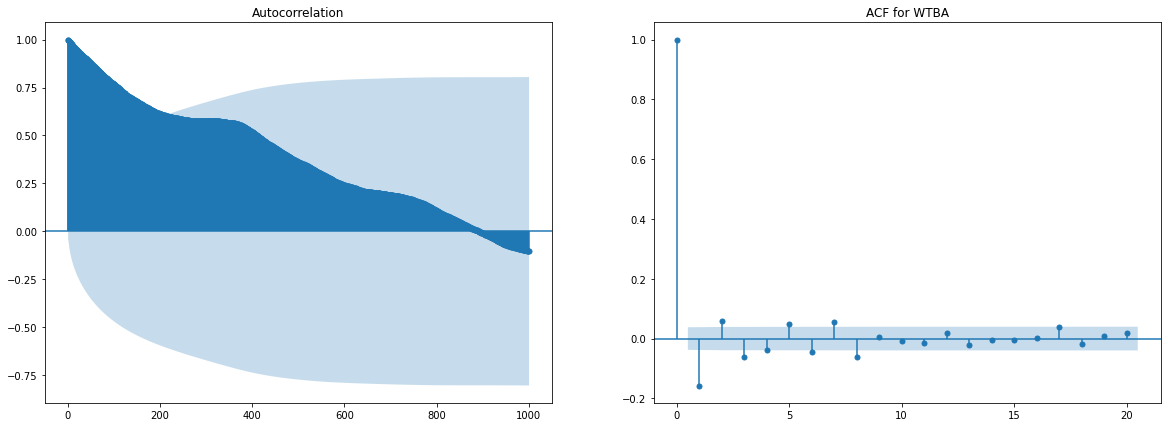

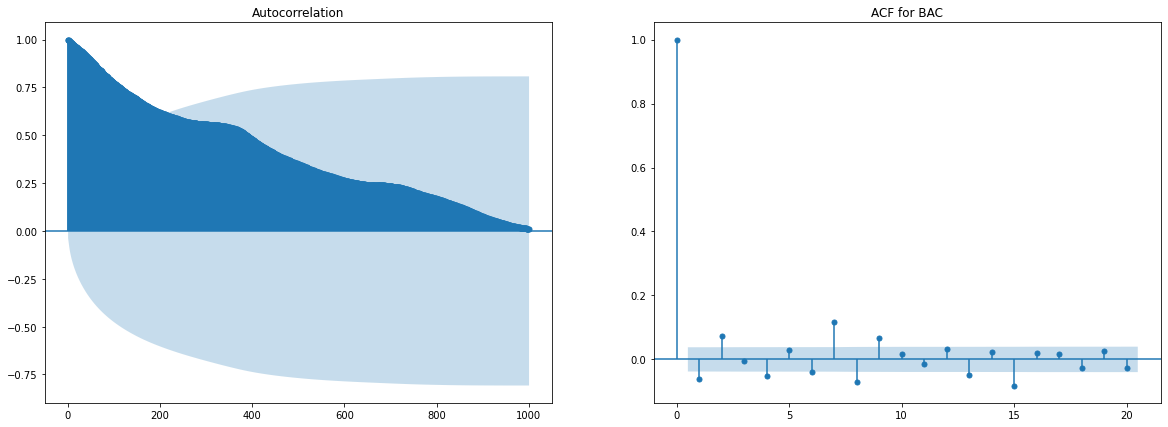

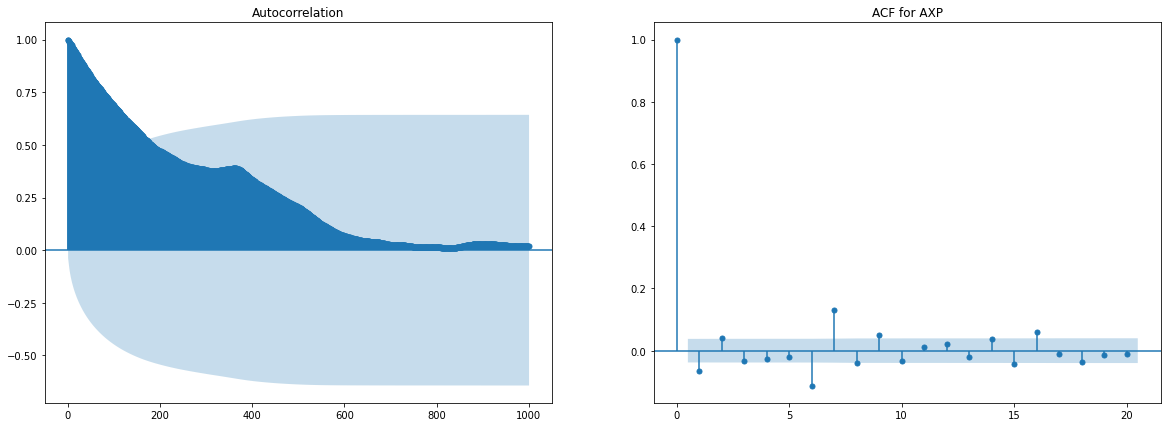

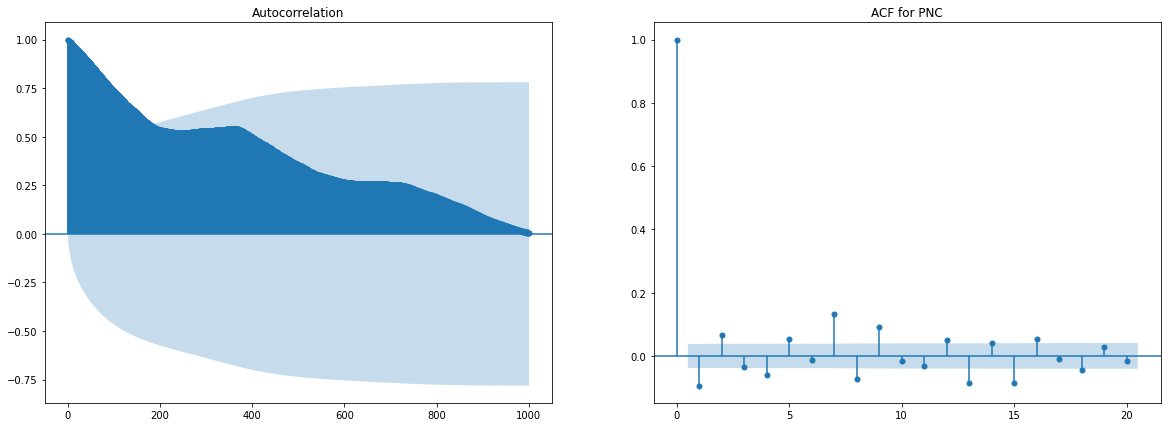

In [12]:
for i in df:
    plt.rcParams["figure.figsize"] = (20,7)
    fig,ax = plt.subplots(1,2)
    sm.graphics.tsa.plot_acf(df[i],lags=1000,ax=ax[0])
    plt.title('ACF for %s' % i)
    sm.graphics.tsa.plot_acf(difference(df[i]),lags=20,ax=ax[1])
    plt.title('ACF for %s' % i)
    plt.show()

## Below are the PACF plots for the non-differenced and differenced time series.
- The PACF plots are not attenuating and this confirms that the time series are autoregressive.
- In order to find the lag of the Autoregressive process the PACF plots are analysed.
- The lag (p) value of the AR time series is where the PACF cuts and goes below the significance level.
- It is found that that for different time seris the PACF plot is cutting at different lags, thus it is better to rely on the **AIC (Akaike Information Criterion)** to find the lag of this multivariate time series.

<Figure size 1080x216 with 0 Axes>

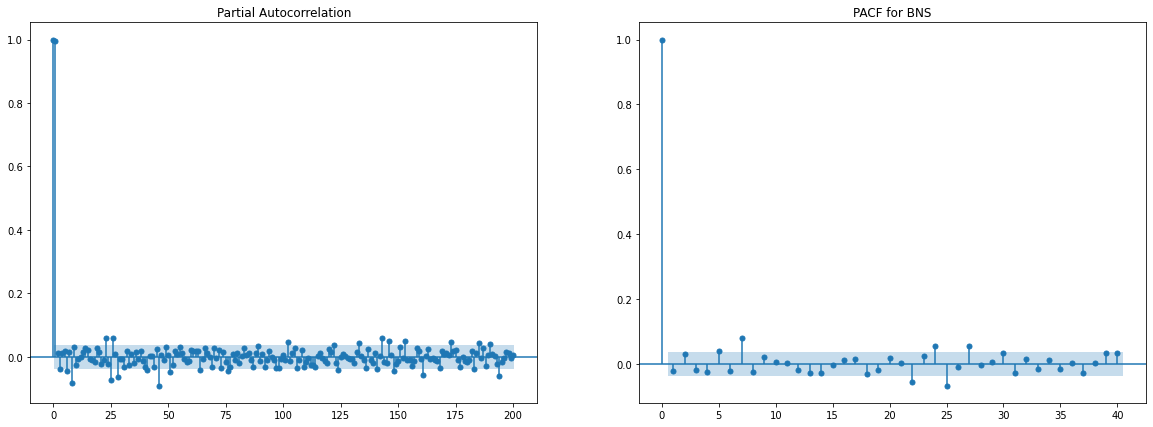

<Figure size 1080x216 with 0 Axes>

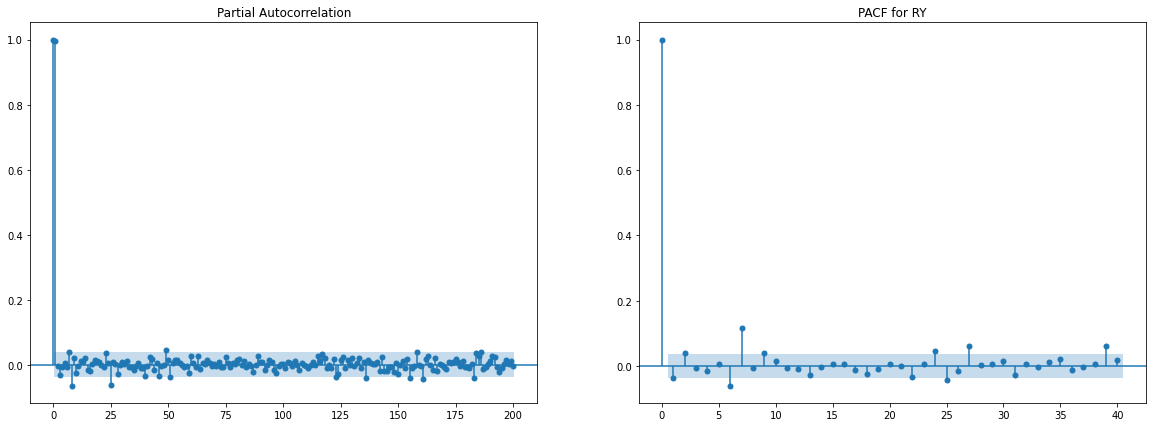

<Figure size 1080x216 with 0 Axes>

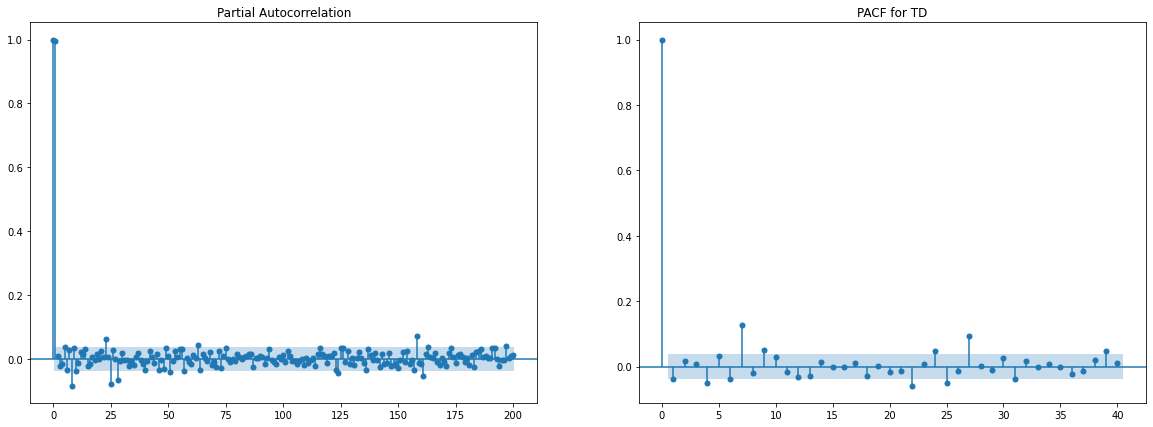

<Figure size 1080x216 with 0 Axes>

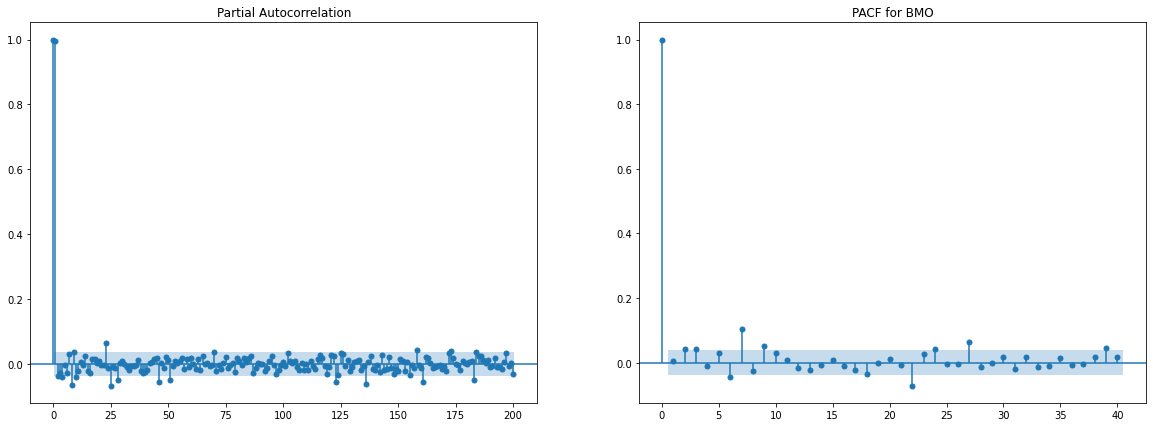

<Figure size 1080x216 with 0 Axes>

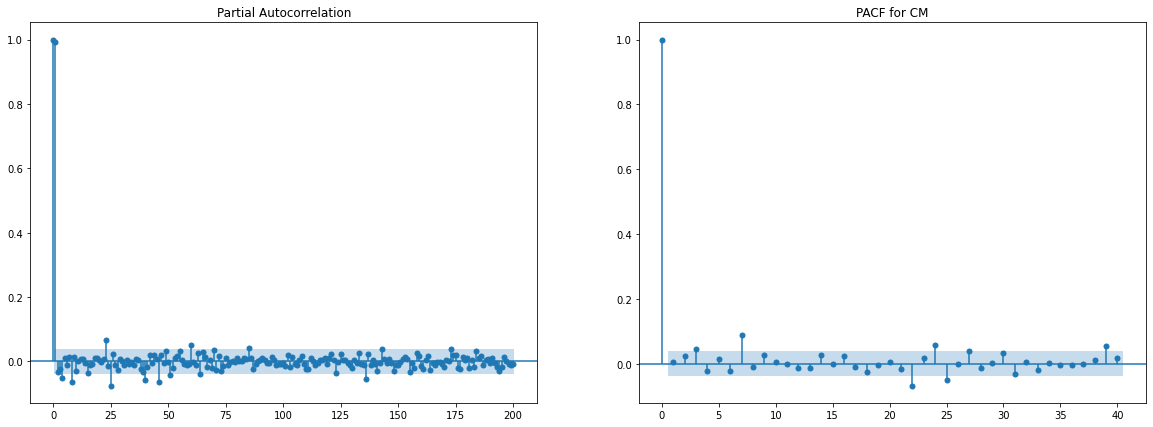

<Figure size 1080x216 with 0 Axes>

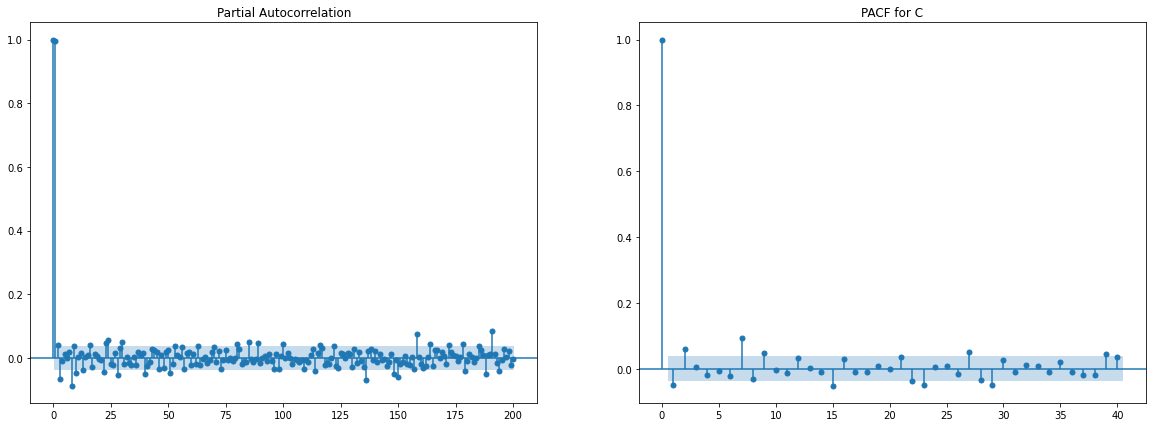

<Figure size 1080x216 with 0 Axes>

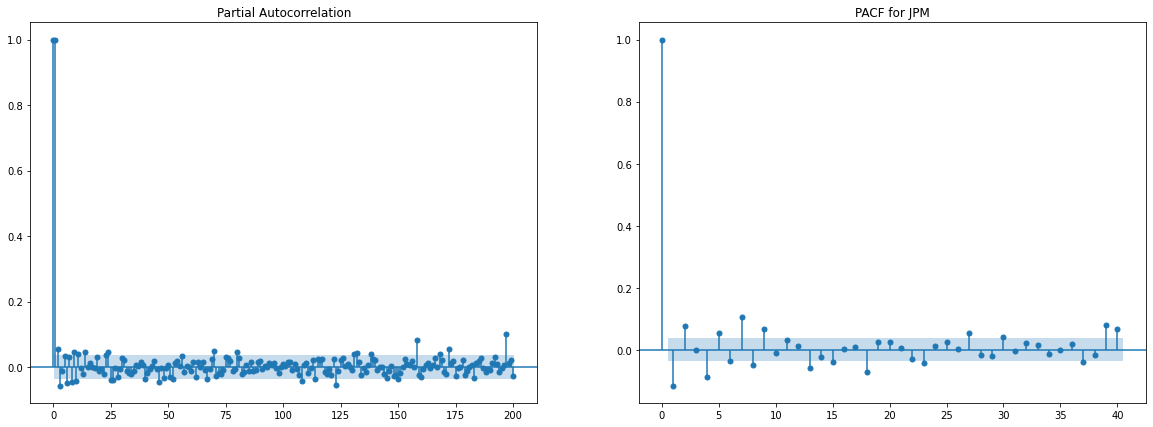

<Figure size 1080x216 with 0 Axes>

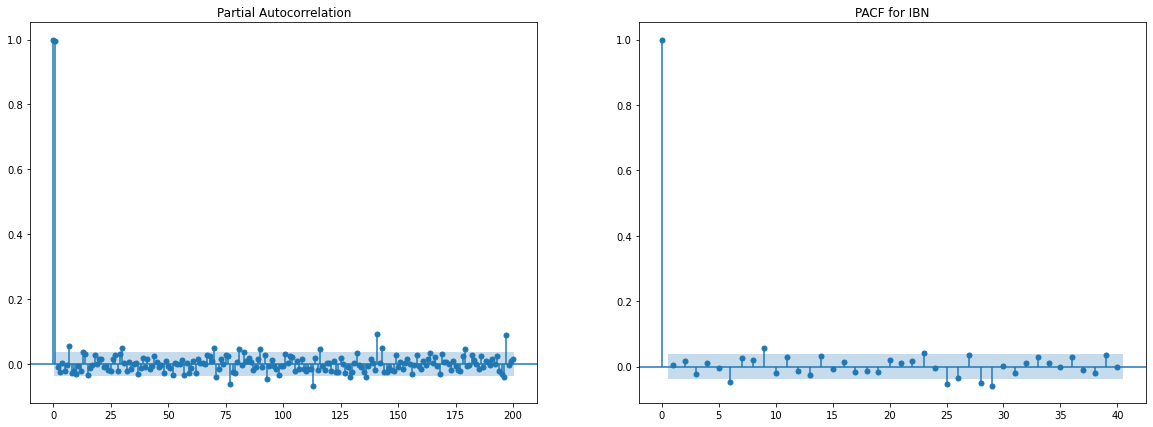

<Figure size 1080x216 with 0 Axes>

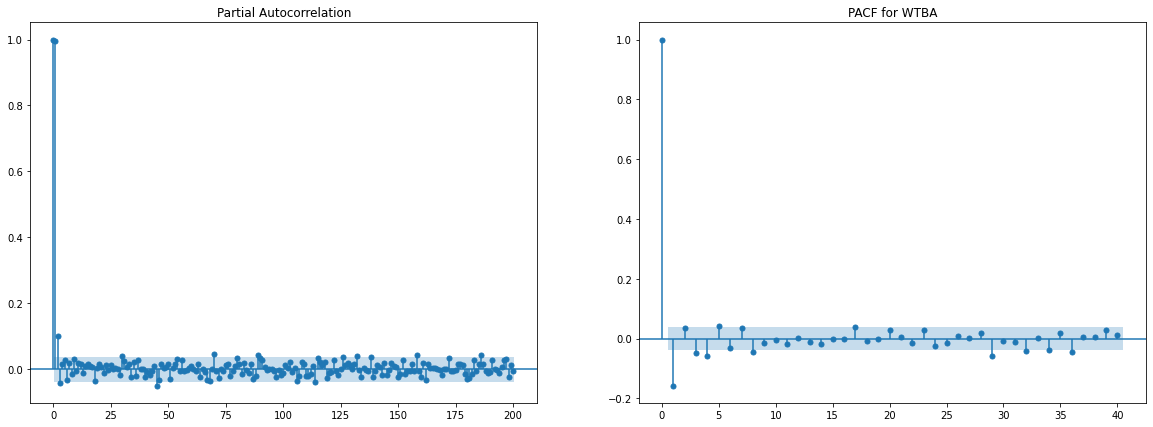

<Figure size 1080x216 with 0 Axes>

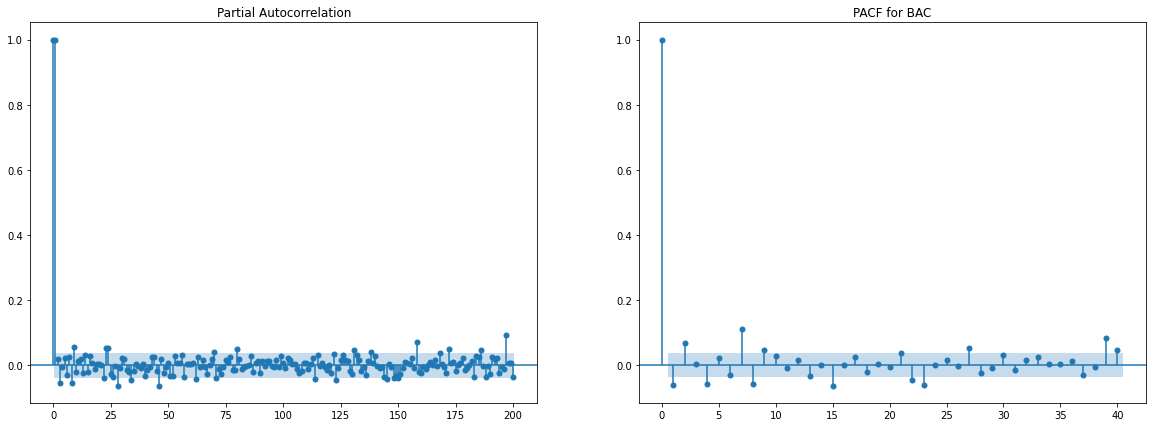

<Figure size 1080x216 with 0 Axes>

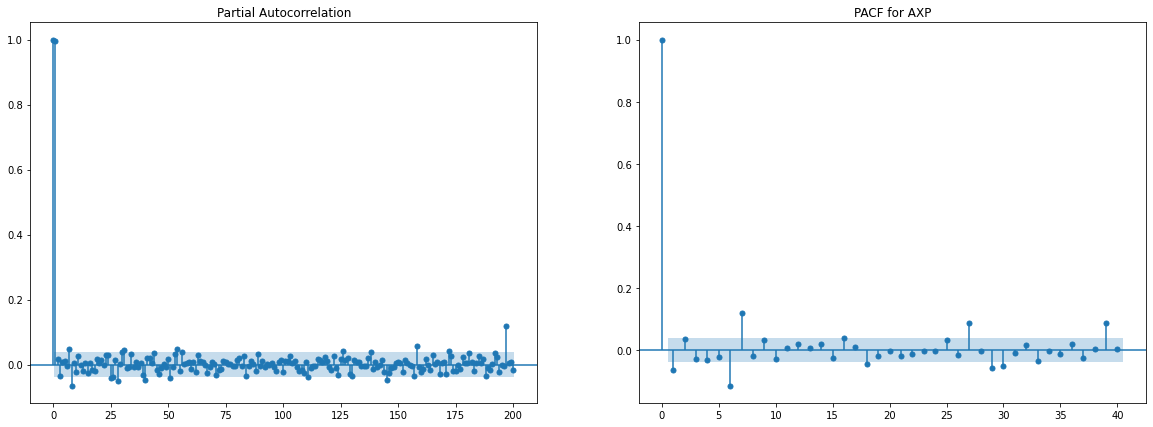

<Figure size 1080x216 with 0 Axes>

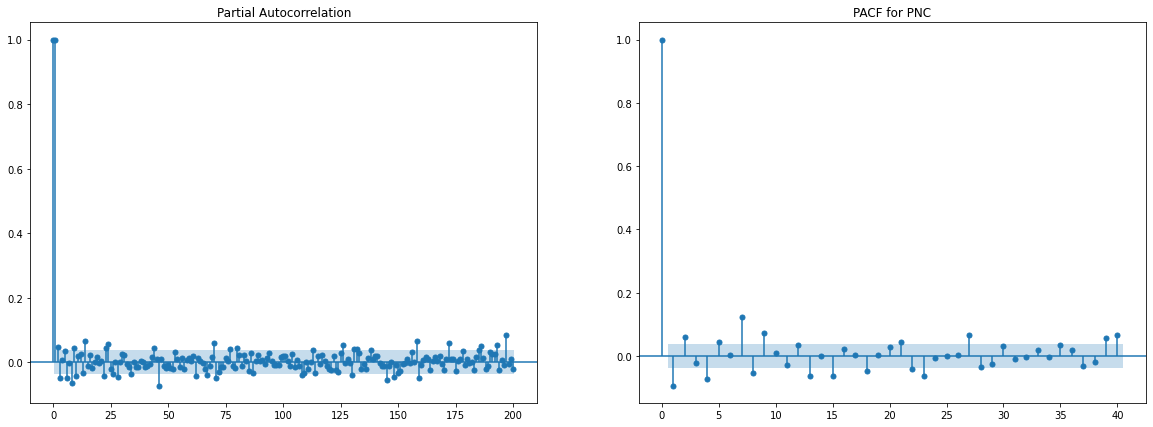

In [13]:
for i in df:
    plt.figure(figsize=(15,3))
    fig,ax = plt.subplots(1,2)
    sm.graphics.tsa.plot_pacf(df[i], lags = 200,ax=ax[0])
    plt.title('PACF for %s' % i)
    sm.graphics.tsa.plot_pacf(difference(df[i]), lags = 40,ax=ax[1])
    plt.title('PACF for %s' % i)

### Visualizing the time series after differencing. The differenced time series look pretty much stationary.

(2675, 12)


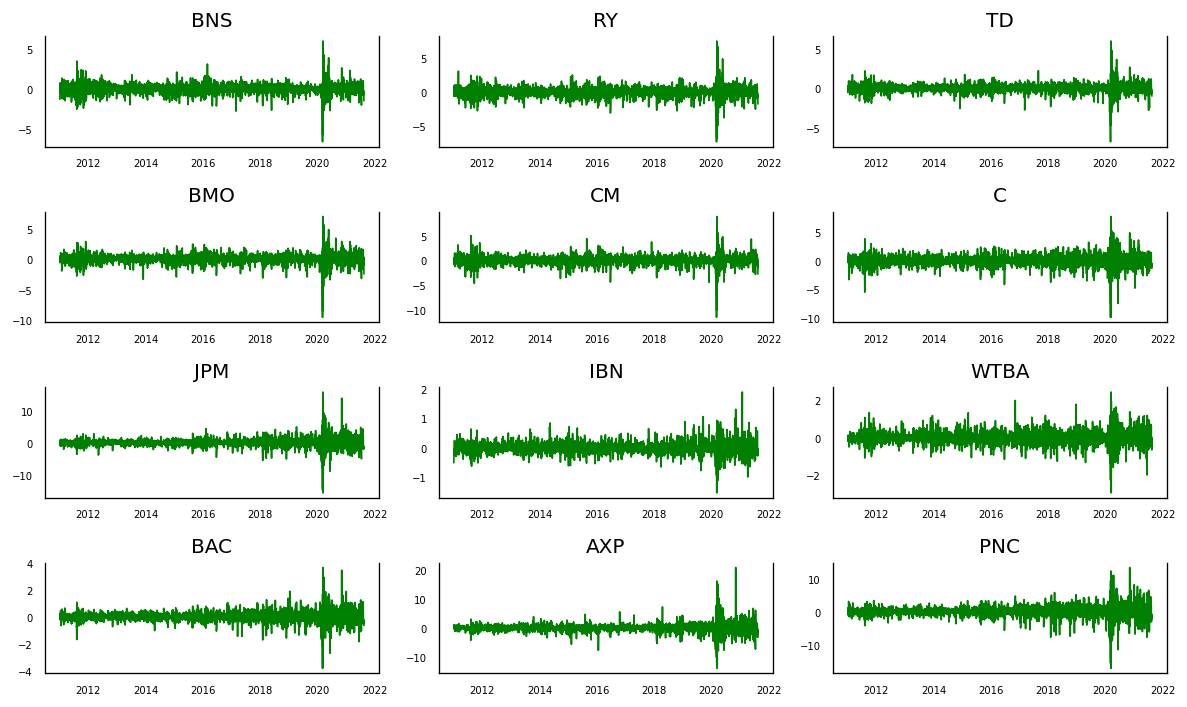

In [102]:
X_diff=df.diff().dropna()
print(X_diff.shape)
fig, axes = plt.subplots(nrows=4, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = X_diff[X_diff.columns[i]]
    ax.plot(data, color='g', linewidth=1)
    ax.set_title(X_diff.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

## Granger’s causality Test
Granger’s causality Test is performed to find if the coefficients of past values in the regression equation are zero.
So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, we can safely reject the null hypothesis. This has been performed on original data-set.

The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, we can predict the series with past values of itself along with other series in the system.

### Since, the p value for majorly all the time series with each other is less than 0.05 we can reject null hypothesis and say that the coefficients of past values in the regression equation is not zero and hence they make a difference to the forecast of each other and add some information to it.

In [105]:
def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False):

    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value

    dataset.columns = [var + '_x' for var in variables]

    dataset.index = [var + '_y' for var in variables]

    return dataset

maxlag=30
grangers_causality_matrix(X_diff, variables = X_diff.columns)

BNS_x    RY_x    TD_x   BMO_x    CM_x     C_x   JPM_x   IBN_x  \
BNS_y   1.0000  0.0192  0.0000  0.0191  0.0302  0.0004  0.0000  0.0610   
RY_y    0.0012  1.0000  0.0000  0.0008  0.0000  0.0000  0.0000  0.0130   
TD_y    0.0000  0.0303  1.0000  0.0003  0.0015  0.0027  0.0000  0.0009   
BMO_y   0.0000  0.0234  0.0000  1.0000  0.0027  0.0152  0.0002  0.0109   
CM_y    0.1120  0.0853  0.0000  0.0430  1.0000  0.0088  0.0003  0.0877   
C_y     0.0002  0.0015  0.0000  0.0046  0.0000  1.0000  0.0000  0.0070   
JPM_y   0.0040  0.0408  0.0000  0.0382  0.0014  0.0002  1.0000  0.0043   
IBN_y   0.0013  0.0029  0.0001  0.0000  0.0000  0.0006  0.0000  1.0000   
WTBA_y  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0003   
BAC_y   0.0002  0.0044  0.0000  0.0017  0.0005  0.3820  0.0013  0.0005   
AXP_y   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0002   
PNC_y   0.0001  0.0004  0.0000  0.0005  0.0001  0.0136  0.0000  0.0019   

        WTBA_x   BAC_x  AXP_x   PNC_x  
BNS_y   0.0113  0.0001    0.0  0.0008  
RY_y    0.0003  0.0000    0.0  0.0004  
TD_y    0.0078  0.0001    0.0  0.0002  
BMO_y   0.0003  0.0000    0.0  0.0000  
CM_y    0.0119  0.0031    0.0  0.0006  
C_y     0.0060  0.0016    0.0  0.0032  
JPM_y   0.0000  0.0001    0.0  0.0000  
IBN_y   0.0006  0.0000    0.0  0.0000  
WTBA_y  1.0000  0.0000    0.0  0.0000  
BAC_y   0.0000  1.0000    0.0  0.0040  
AXP_y   0.0000  0.0000    1.0  0.0000  
PNC_y   0.0070  0.0000    0.0  1.0000

## Fitting the Vector Autoregressive (VAR) Model to the multivariate time series.

In [106]:
mod = VAR(X_diff)
res = mod.fit(maxlags=10, ic='aic')
print(res.summary())
y_fitted = res.fittedvalues

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 19, Aug, 2021
Time:                     22:40:07
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                   -18.6391
Nobs:                     2672.00    HQIC:                  -19.2638
Log likelihood:          -18843.3    FPE:                3.02026e-09
AIC:                     -19.6179    Det(Omega_mle):     2.56079e-09
--------------------------------------------------------------------
Results for equation BNS
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.001447         0.013077            0.111           0.912
L1.BNS         -0.058734         0.042694           -1.376           0.169
L1.RY          -0.043126         0.036927           -1.168           0.243
L1.TD      

## If the model is fit well the residuals should pass the whiteness test.

## Finding residuals and performing whiteness test

### If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.

The residuals should follow the following:
- They should be uncorrelated.
- They should have mean around 0
- They should have constant variance.
- They should be normally distributed

### From the plot below we can see that the variance is constant and mean is around 0

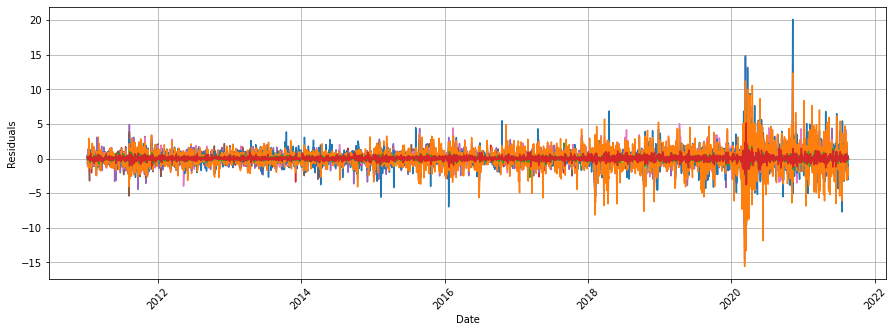

In [107]:
residuals= res.resid
plt.figure(figsize = (15,5))
plt.plot(residuals, label='resid')
plt.plot(y_fitted, label='VAR prediction')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Residuals')
plt.grid(True)


## The residuals have a normal distribution as well which is also one of the important characteristic of the residuals.

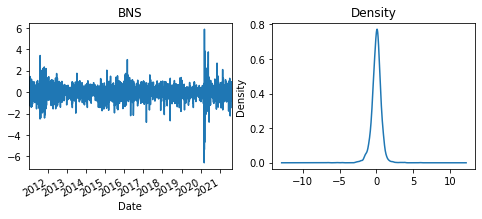

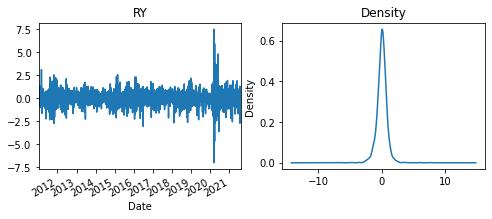

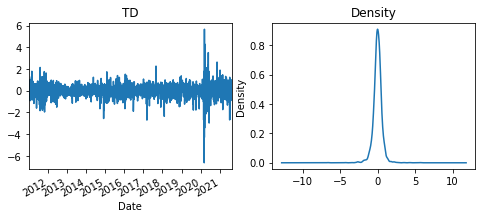

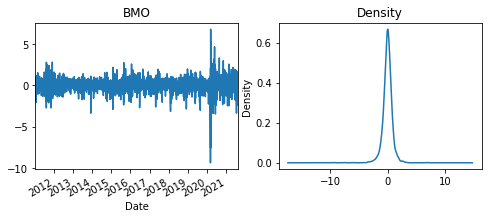

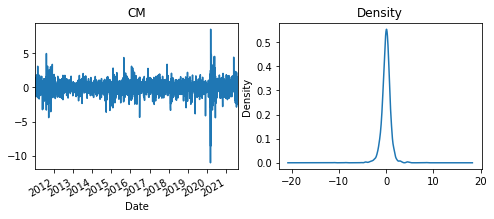

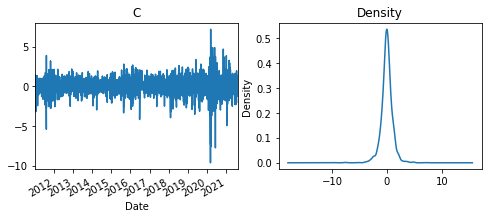

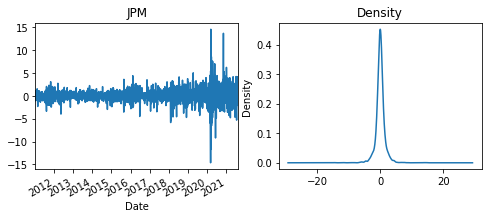

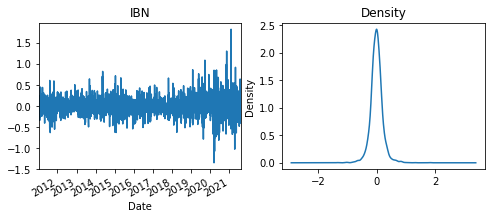

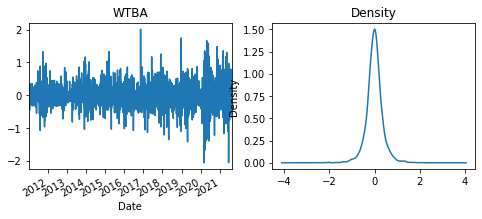

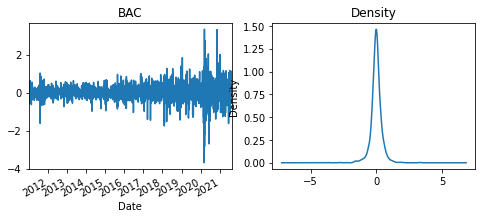

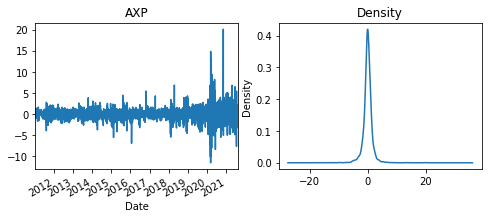

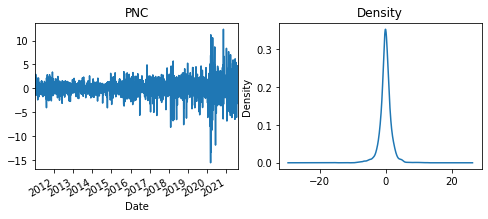

In [108]:
#re = invert_transformation_re(X_train, residuals)
for i in residuals.columns:
    r=residuals[i]
    #print(re.mean())
    plt.rcParams["figure.figsize"] = (8,3)
    fig,ax = plt.subplots(1,2)
    r.plot(title=i,ax=ax[0])
    r.plot(kind='kde',title="Density",ax=ax[1])
    plt.show()
    

## The Durbin-Watson statistic will always have a value between 0 and 4. A value of 2.0 means that there is no auto-correlation detected in the sample. Values from 0 to less than 2 indicate positive auto-correlation and values from 2 to 4 indicate negative auto-correlation. A rule of thumb is that test statistic values in the range of 1.5 to 2.5 are relatively normal. Any value outside this range could be a cause for concern.

### The value of the Durbin-Watson statistic suggest that the residuals are white and they have no significant auto-correlation.

In [109]:
from statsmodels.stats.stattools import durbin_watson
out=durbin_watson(res.resid)

for col,val in zip(X_diff.columns,out):
    print((col),":",round(val,2))

BNS : 1.99
RY : 1.99
TD : 1.99
BMO : 1.99
CM : 1.99
C : 2.0
JPM : 2.0
IBN : 2.0
WTBA : 2.0
BAC : 2.0
AXP : 2.0
PNC : 2.0


In [110]:
lag_order = res.k_ar
# Input data for forecasting which is 30 days data input
input_data = X_diff.values[-lag_order:]
print(input_data.shape)

(3, 12)



## Box-Ljung Test (Whiteness Test)

Finally to confirm tat the residuals are white we perform the Box-Ljung test.

- Null Hypothesis: Discrete white noise is a good fit to residuals
- Alternate Hypothesis: Residuals are not white

Since, the p value is greater than 0.05 hence we can say that the noise is white for all the time series.

In [111]:
for i in residuals.columns:
    val=sm.stats.acorr_ljungbox(residuals[i], lags=[lag_order], return_df=True).values
    p=val[0][1]
    print(p)
    if p > 0.05:
        print("For {} Discrete white noise is a good fit to residuals".format(i))
    else:
        print("For {} Discrete white noise is not a good fit to residuals".format(i))

0.9920226106914389
For BNS Discrete white noise is a good fit to residuals
0.9588728544504649
For RY Discrete white noise is a good fit to residuals
0.9832866805857883
For TD Discrete white noise is a good fit to residuals
0.9817896837253973
For BMO Discrete white noise is a good fit to residuals
0.9909864362768769
For CM Discrete white noise is a good fit to residuals
0.9835397083601419
For C Discrete white noise is a good fit to residuals
0.838686899060085
For JPM Discrete white noise is a good fit to residuals
0.9700956519902716
For IBN Discrete white noise is a good fit to residuals
0.9600893774701803
For WTBA Discrete white noise is a good fit to residuals
0.9827063035469679
For BAC Discrete white noise is a good fit to residuals
0.8550632162725594
For AXP Discrete white noise is a good fit to residuals
0.9214385282509738
For PNC Discrete white noise is a good fit to residuals


## Finding the prediction for 5 steps ahead (since saturday and sunday have no closing value), so thursday to thurday is 5 steps ahead.

In [112]:
# Creating the indexes for future dates from 20th August to 26th August
base = datetime.today() + timedelta(days=1)
end_d= datetime.today() + timedelta(days=7)
per1 = pd.date_range(start =base.date(), end =end_d.date(), freq ='D')
weekends = [5,6]
r=[]
for i in per1:
    if i.weekday() not in weekends:
        r.append(i)
pred = res.forecast(y=input_data, steps=5)
pred = pd.DataFrame(pred, index=r, columns=X_diff.columns + '_pred')

## Value of Closing price for current Thursday

In [113]:
thurs_current=df[-1:]
thurs_current

BNS          RY         TD        BMO     CM          C  \
Date                                                                        
2021-08-19  62.040001  101.610001  66.720001  98.860001  114.5  69.839996   

                   JPM        IBN       WTBA        BAC         AXP  \
Date                                                                  
2021-08-19  154.279999  18.549999  29.889999  40.189999  159.029999   

                   PNC  
Date                    
2021-08-19  184.339996

## The forecast from the Statistical Method 1 for 5 steps ahead for all banks

In [115]:
# inverting transformation
def invert_transformation(X_train, pred):
    forecast = pred.copy()
    columns = X_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast
output = invert_transformation(df, pred)
output.columns = m_df.columns
output

BNS          RY         TD        BMO          CM  \
2021-08-20  61.938517  101.441059  66.638301  98.715769  114.272479   
2021-08-23  61.809316  101.266699  66.530458  98.509914  114.160184   
2021-08-24  61.921559  101.503576  66.658930  98.596488  114.213292   
2021-08-25  61.905967  101.466487  66.649544  98.562636  114.201595   
2021-08-26  61.883044  101.458258  66.635277  98.533572  114.161616   

                    C         JPM        IBN       WTBA        BAC  \
2021-08-20  69.973169  154.605076  18.568982  29.835438  40.283028   
2021-08-23  69.677358  154.184547  18.546657  29.770167  40.203661   
2021-08-24  69.737432  154.590889  18.535800  29.889021  40.255193   
2021-08-25  69.666810  154.521657  18.536875  29.861347  40.233379   
2021-08-26  69.652147  154.534199  18.531130  29.879174  40.239151   

                   AXP         PNC  
2021-08-20  159.400143  184.773116  
2021-08-23  159.294938  184.310179  
2021-08-24  159.315273  184.791653  
2021-08-25  159.213786  184.694226  
2021-08-26  159.222868  184.757400

<a id="dl1"><a>
# 2. Univariate forecast using Gated Recurrent Unit

- In this method a simple DL model with two layers of GRUs is used for forecasting the 5 steps ahead closing price. Different models were used (compound and complex ones with attention as well) and it was found that this particular model was working the best and hence this is used for forecasting.

- This model is fed with past 20 values of the closing price i.e. the past four weeks data to forecast the 5 days ahead closing price for each bank.

- This is a simple price to price mapping and univariate forecasting using a simple DL model

- The mapping of the data is done in such a way that 20 inputs of the past corresoinds to the input features of the model and the label is the 5 weeks ahead closing price.

## Following are the functions defined for forecasting using the Univariate series using the DL model

In [133]:
lag = 20
steps_ahead = 5
n_features = 1

# Function to convert the time series into window of lags
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg
"""
This function scales and divides the data into features and labels.
It return the training input and labels, the input to forecast 5 steps in future 
and the scaler fit on the input samples
"""
def preprocess_dl(lag,steps_ahead,df):
    scaler = MinMaxScaler(feature_range=(0,1))
    df = scaler.fit_transform(df)
    y_train=df[lag+steps_ahead-1:]
    x=series_to_supervised(df,lag-1)
    x_train=x[:len(y_train)].values
    x_input=x[-steps_ahead:].values
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_input = x_input.reshape((x_input.shape[0], x_input.shape[1], 1))
    return x_train,x_input,y_train,scaler

"""
Defining the model for training
"""
def model_univariate(lag,n_features):
    os.environ['PYTHONHASHSEED'] = '42'
    np.random.seed(42)
    np.random.RandomState(42)
    random.seed(42)
    
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape= (lag, n_features)))
    #model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(GRU(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    return model

# Function for training the model and saving the best weights in the path passed as parameter to function
def train_univariate(model,x_train,y_train,path):
    reduce_lr = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
    checkpoint1 = keras.callbacks.ModelCheckpoint(path,
                                                     monitor='val_loss',
                                                     save_best_only=True,
                                                     mode='min')
    es=keras.callbacks.EarlyStopping(patience=5)
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    history=model.fit(x_train,y_train,epochs=50,validation_split=0.2,verbose=0,batch_size=32,callbacks=[reduce_lr,checkpoint1,es])


# Function called to forecast the values by loading the saved weights into the passed model. 
def predict_dl(model,path,x_test,scaler):
    model.load_weights(path)
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    return predictions
    

## Forecasting the values for 5 steps ahead for all the banks by calling the functions defined above.

In [134]:
out_dl=[]
for ticker in df.columns:
    print("For, ",ticker)
    path="bestweight"+ticker+".hdf5"
    x_train,x_input,y_train,scaler=preprocess_dl(lag,steps_ahead,df[ticker].values.reshape(-1,1))
    model1=model_univariate(lag,n_features)
    train_univariate(model1,x_train,y_train,path)
    print("Training Complete")
    predictions=predict_dl(model1,path,x_input,scaler)
    out_dl.append(predictions)
    print("Forecast for  next Thursday",predictions[-1:][0][0])


For,  BNS
Training Complete
Forecast for  next Thursday 62.24638
For,  RY
Training Complete
Forecast for  next Thursday 102.11854
For,  TD
Training Complete
Forecast for  next Thursday 66.958496
For,  BMO
Training Complete
Forecast for  next Thursday 99.34464
For,  CM
Training Complete
Forecast for  next Thursday 115.47129
For,  C
Training Complete
Forecast for  next Thursday 70.414276
For,  JPM
Training Complete
Forecast for  next Thursday 155.2426
For,  IBN
Training Complete
Forecast for  next Thursday 18.617289
For,  WTBA
Training Complete
Forecast for  next Thursday 30.037867
For,  BAC
Training Complete
Forecast for  next Thursday 40.413944
For,  AXP
Training Complete
Forecast for  next Thursday 162.22462
For,  PNC
Training Complete
Forecast for  next Thursday 185.24945


## The forecasted values from the Univariate DL model for all the banks for the 5 steps ahead in future.

In [135]:
out_dl=np.asarray(out_dl)
DL=pd.DataFrame(out_dl.reshape(12,5),index=tickers,columns=r).T
DL

BNS          RY         TD         BMO          CM  \
2021-08-20  64.529999  104.465294  68.802750  102.312302  118.070541   
2021-08-23  64.318436  104.257278  68.604416  101.796005  118.083649   
2021-08-24  63.754486  103.705536  68.156303  100.957146  117.379723   
2021-08-25  63.372677  103.248932  67.700928  100.657295  116.924789   
2021-08-26  62.246380  102.118538  66.958496   99.344643  115.471291   

                    C         JPM        IBN       WTBA        BAC  \
2021-08-20  73.463158  160.128616  19.353287  31.111618  41.649940   
2021-08-23  72.598045  159.402435  19.226236  31.073980  41.392799   
2021-08-24  71.919472  158.082275  19.012783  30.757978  41.125416   
2021-08-25  71.361374  156.635681  18.758451  30.300253  40.840714   
2021-08-26  70.414276  155.242599  18.617289  30.037867  40.413944   

                   AXP         PNC  
2021-08-20  168.468735  191.424866  
2021-08-23  167.273438  190.211334  
2021-08-24  166.168259  188.692871  
2021-08-25  164.525375  186.851135  
2021-08-26  162.224625  185.249451

<a id="stat2"><a>
# 3. Statistical Method 2: Multivariate forecasting considering the open, close, low, high, volume stock price

In this method the Vector Autoregressive Model is fit for all the banks individually unlike the [Statistical method 1](#stat1) in which the VAR model was just fitted once on the closing prices of all the 12 banks.

Here all the prices close, open, high, low, adjusted close are taken in consideration to forecast the closing price 5 steps in future. 

In [136]:
# Function to perform inverse differencing
def invert_transformation(X_train, pred):
    forecast = pred.copy()
    columns = X_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast

# function which returns the forecast for 5 steps in future, here 'r' is the list of 5 dates in future.
def statistical_model(df,r):
    X_train=df
    X_diff=X_train.diff().dropna()
    mod = VAR(X_diff)
    res = mod.fit(maxlags=30, ic='aic')
    y_fitted = res.fittedvalues
    lag_order = res.k_ar
    input_data = X_diff.values[-lag_order:]
    pred = res.forecast(y=input_data, steps=5)
    pred = pd.DataFrame(pred, index=r, columns=X_train.columns + '_pred')
    output = invert_transformation(X_train, pred)
    prediction=output["Close_pred"].values

    return prediction

In [137]:
# function which returns the stock price data of the bank on passing the ticker as paramter
def get_data(ticker):
    df = DataReader(ticker, data_source='yahoo', start='2011-01-01', end=datetime.now())
    return df
lag = 10
steps_ahead = 5
n_features = 1
out_stat=[]

# Fitting the VAR model on the data of all banks to obtain the Closing price in future.
for tick in ['BNS', 'RY', 'TD','BMO','CM','C','JPM','IBN', 'WTBA','BAC','AXP','PNC']:
    print("For, ",tick)
    d=get_data(tick)
    pred=statistical_model(d,r)
    print("Forecast for next Thursday",pred[-1:][0])
    out_stat.append(pred)
    


For,  BNS
Forecast for next Thursday 61.33869493610419
For,  RY
Forecast for next Thursday 101.21163442139591
For,  TD
Forecast for next Thursday 66.55443234221812
For,  BMO
Forecast for next Thursday 97.62856985745418
For,  CM
Forecast for next Thursday 112.80125919164936
For,  C
Forecast for next Thursday 70.27719918449688
For,  JPM
Forecast for next Thursday 152.21230342279242
For,  IBN
Forecast for next Thursday 18.597648120827884
For,  WTBA
Forecast for next Thursday 29.78367347917357
For,  BAC
Forecast for next Thursday 40.05316307493603
For,  AXP
Forecast for next Thursday 159.53270467611782
For,  PNC
Forecast for next Thursday 182.5619116120496


## The forecasted values from the Statistical Method 1 for all the banks for the 5 steps ahead in future.

In [138]:
out_stat=np.asarray(out_stat)
STAT=pd.DataFrame(out_stat.reshape(12,5),index=tickers,columns=r).T
STAT

BNS          RY         TD        BMO          CM  \
2021-08-20  61.908484  101.941531  66.789072  98.595277  114.035512   
2021-08-23  62.010844  101.658250  66.935781  98.697571  114.024700   
2021-08-24  61.654425  101.525078  66.929309  98.298710  113.211064   
2021-08-25  61.441698  101.251013  66.697603  97.940291  113.181143   
2021-08-26  61.338695  101.211634  66.554432  97.628570  112.801259   

                    C         JPM        IBN       WTBA        BAC  \
2021-08-20  70.161422  152.999410  18.580249  29.838655  40.055469   
2021-08-23  70.032453  152.778371  18.549173  29.906132  40.068499   
2021-08-24  69.974633  152.760654  18.576159  29.943665  40.040789   
2021-08-25  70.254804  153.091038  18.578892  29.957404  40.222459   
2021-08-26  70.277199  152.212303  18.597648  29.783673  40.053163   

                   AXP         PNC  
2021-08-20  160.407572  184.695932  
2021-08-23  158.129824  184.906027  
2021-08-24  158.836769  184.885851  
2021-08-25  159.108114  184.215385  
2021-08-26  159.532705  182.561912

<a id="dl2"><a>

# 4. News Sentiment Anlysis for Stock Price Prediction: Forecasting the close price using the derived sentiments from news and historical close prices.

In this approach the sentiment analysis from the news headlines is performed using the finwiz website.

The following steps have been performed:
- The news related to the stocks of the considered banks is extracted from the finviz website found on the url https://finviz.com/quote.ashx?t=BNS

- After extracting the news headline related to the particular bank it is converted into a dataframe with the date, time, ticker symbol and headline.
- In the next step the SentimentIntensityAnalyzer is used from the nltk.sentiment.vader library to assign sentiment scores to each headline. The score are granted under the columns positve, negative, neutral and compound. The main column is the **compound** one, which has the overall sentiment score.
- In the next step for every bank the mean of the compound sentiment for every day over all the time stamps in a day is calculated.
- The next step is to perform the interpolation of the sentiment score in order to make the time series complete.

In [46]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
finwiz_url = 'https://finviz.com/quote.ashx?t='
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mohita/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


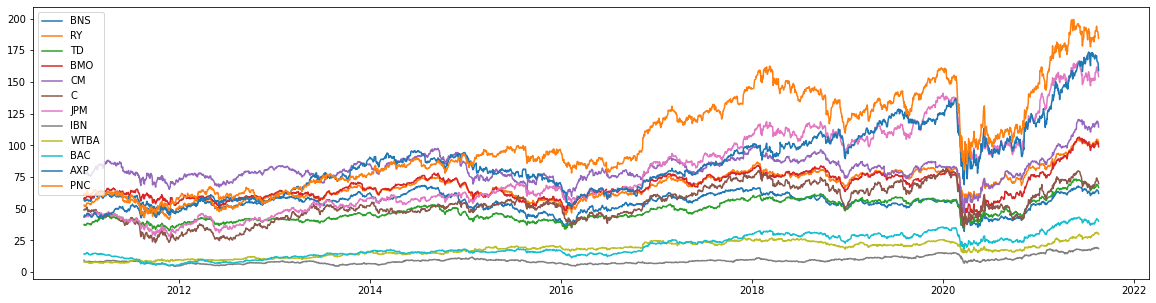

In [146]:
plt.rcParams["figure.figsize"]=(20,5)
def plot_data(ticker):
    df = DataReader(ticker, data_source='yahoo', start='2011-01-01', end=datetime.now())
    plt.plot(df["Close"],label=ticker)
    plt.legend()
    return df
for i in tickers:
    plot_data(i)

## News data Ingestion using web scraping
### Code snippet to store the news in the dictionary

In [147]:
news = {}
for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    html = BeautifulSoup(response)
    table = html.find(id='news-table')
    news[ticker] = table

## The following code shows the headlines extracted for Scotiabank

In [148]:
bns= news['BNS']
bns_tr = bns.findAll('tr')

for i, table_row in enumerate(bns_tr):
    # stores the headline
    a_text = table_row.a.text
    # stores the time
    td_text = table_row.td.text
    print(a_text)
    print(td_text)
    if i == 10:
        break

Scotiabank recognized for Outstanding Leadership in the Global Finance 2021 Sustainable Finance Awards
Aug-19-21 09:41AM  
Scotiabank Issues USD 1 Billion Sustainability Bond
09:01AM  
Bank of Nova Scotia (BNS) Reports Next Week: Wall Street Expects Earnings Growth
Aug-17-21 03:00PM  
Scotiabank to Announce Third Quarter 2021 Results
09:00AM  
Scotiabank to Announce Third Quarter 2021 Results
Aug-05-21 09:00AM  
Could The The Bank of Nova Scotia (TSE:BNS) Ownership Structure Tell Us Something Useful?
02:16AM  
Scotiabank launches new credit card payment plan feature
Aug-04-21 07:00AM  
Scotiabank Issues USD 1 Billion Sustainability Bond
Aug-03-21 09:00AM  
Scotiabank Named Most Innovative in Data by The Banker Magazine
08:00AM  
10 Best Financial Stocks that Pay Dividends
Jul-30-21 10:10AM  
Fortis inc (FTS) Q2 2021 Earnings Call Transcript
Jul-29-21 11:32PM  


In [185]:
# Parsing the news
extract_news = []
for file_name, news_table in news.items():
    for x in news_table.findAll('tr'):
        text = x.a.get_text() 
        date_scrape = x.td.text.split()
        if len(date_scrape) == 1:
            time = date_scrape[0]   
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        ticker = file_name.split('_')[0]
        extract_news.append([ticker, date, time, text])
extract_news[-5:]

[['PNC',
  'Apr-16-21',
  '11:16AM',
  'PNC Financial Shares Rise After Q1 Earnings Blow Past Estimates; Target Price $192'],
 ['PNC',
  'Apr-16-21',
  '08:44AM',
  'PNC Financial (PNC) Q1 Earnings Beat on Decline in Provisions'],
 ['PNC',
  'Apr-16-21',
  '08:15AM',
  'The PNC Financial Services Group, Inc (PNC) Surpasses Q1 Earnings and Revenue Estimates'],
 ['PNC',
  'Apr-16-21',
  '07:30AM',
  'The PNC Financial Services Group, Inc. to Host Earnings Call'],
 ['PNC',
  'Apr-16-21',
  '06:49AM',
  'PNC Reports First Quarter 2021 Net Income Of $1.8 Billion, $4.10 Diluted EPS']]

In [150]:
columns = ['ticker', 'date', 'time', 'headline']

parsed_and_scored_news = pd.DataFrame(extract_news, columns=columns)

# Creating the instance of the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()


#Finding the polarity scores using vader for every headline
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()
scores_df = pd.DataFrame(scores)

# Joining news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

ticker        date     time  \
0    BNS  2021-08-19  09:41AM   
1    BNS  2021-08-19  09:01AM   
2    BNS  2021-08-17  03:00PM   
3    BNS  2021-08-17  09:00AM   
4    BNS  2021-08-05  09:00AM   

                                            headline  compound  neg    neu  \
0  Scotiabank recognized for Outstanding Leadersh...    0.7906  0.0  0.611   
1  Scotiabank Issues USD 1 Billion Sustainability...    0.0000  0.0  1.000   
2  Bank of Nova Scotia (BNS) Reports Next Week: W...    0.3818  0.0  0.822   
3  Scotiabank to Announce Third Quarter 2021 Results    0.0000  0.0  1.000   
4  Scotiabank to Announce Third Quarter 2021 Results    0.0000  0.0  1.000   

     pos  
0  0.389  
1  0.000  
2  0.178  
3  0.000  
4  0.000

In [151]:
# Creating a new dataframe main_f with all the dates from 26-12-2018 to current date.
main_f=pd.DataFrame()
main_f["Dates"]=n_range=pd.date_range("2018-12-26",datetime.now())
main_f.index=main_f["Dates"]
del main_f["Dates"]                    

# Grouping the parsed_and_scored_news dataframe by the banks and dates 
#and finding the mean of the compound score for every day
for tick in tickers:
    t_f=pd.DataFrame()
    t_f[tick]=parsed_and_scored_news[parsed_and_scored_news["ticker"]==tick].groupby(['date']).mean()['compound']
    main_f=pd.concat([main_f, t_f], axis=1)

### On plotting the mean compound score for all the banks we observe there are lot of missing values before March 2021. Hence we drop all the rows before March 2021.

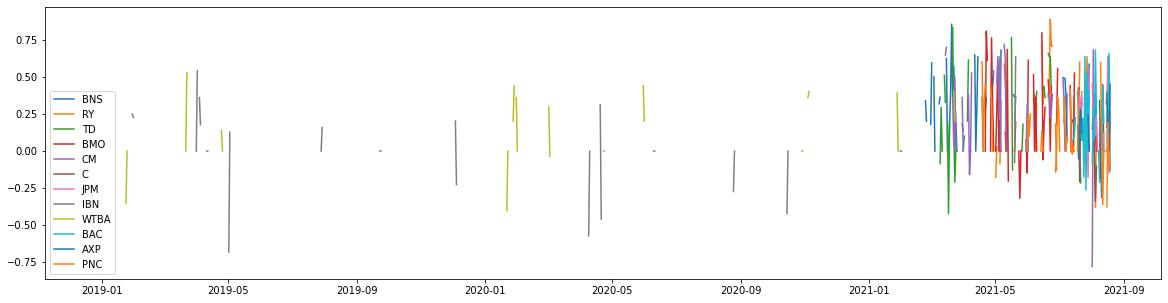

In [152]:
plt.rcParams["figure.figsize"] = (20,5)
for i in main_f.columns:
    plt.plot(main_f[i],label=i)
    plt.legend()

### On dropping the data before March 2021, we obtain the sentiment score time series as follows.

### We can still observe lots of missing values in the series and hence it needs to be imputed.

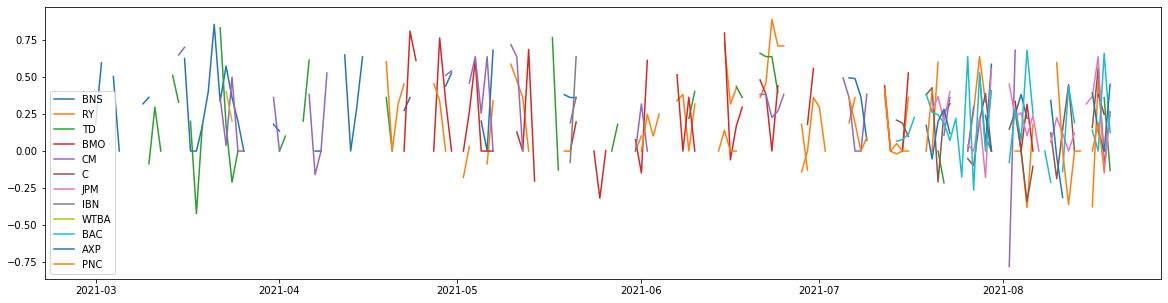

In [153]:
for i in main_f.columns:
    plt.plot(main_f.iloc[796:][i],label=i)
    plt.legend()

## Imputation using interpolation
### On imputing the time series by interpolation we observe the following plots for the compound sentiment score for all the banks

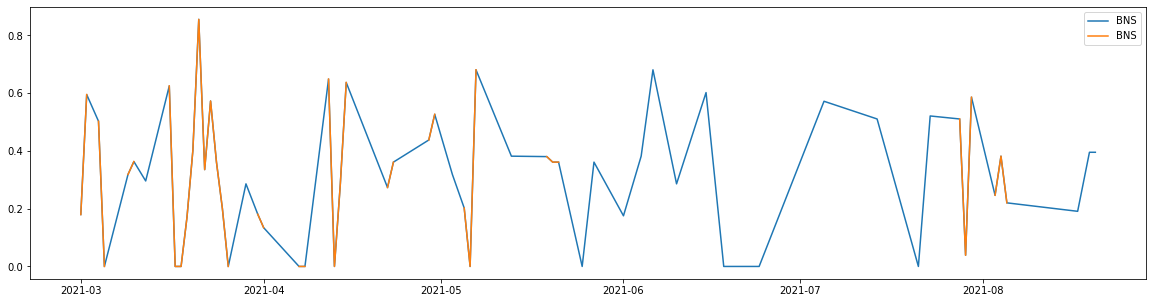

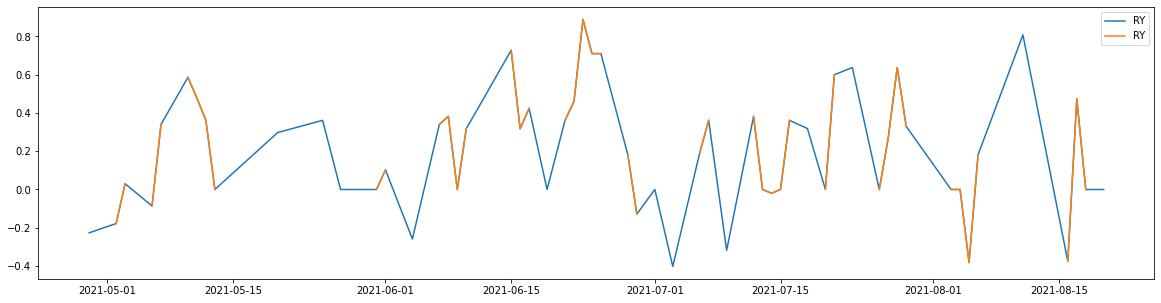

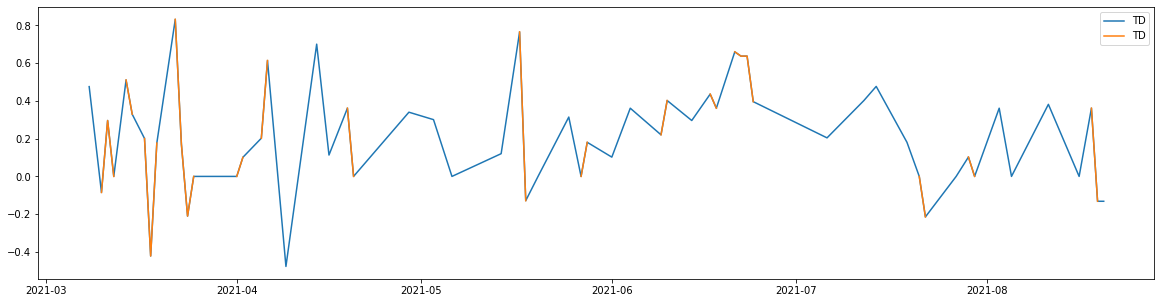

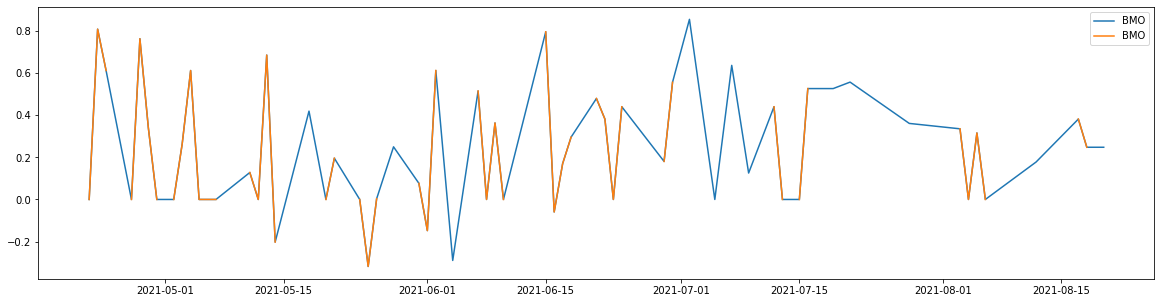

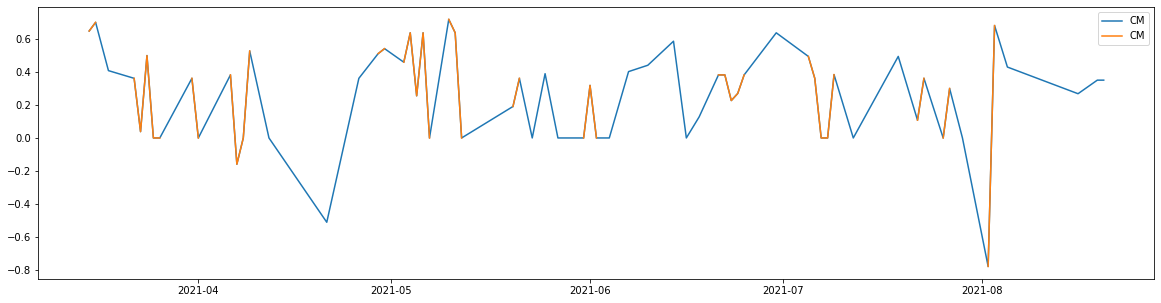

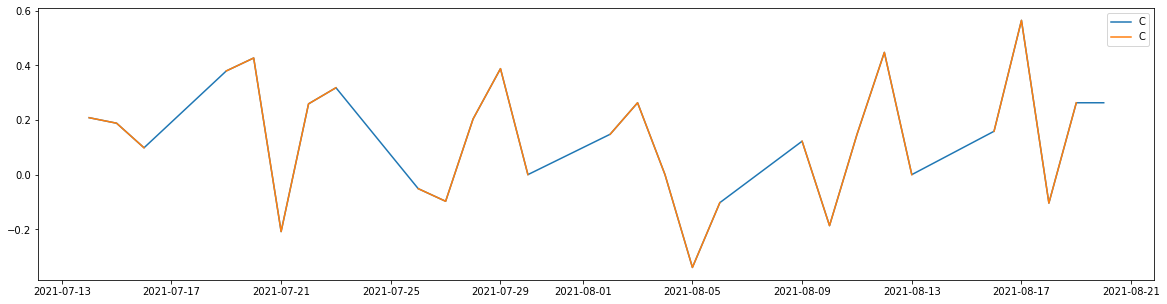

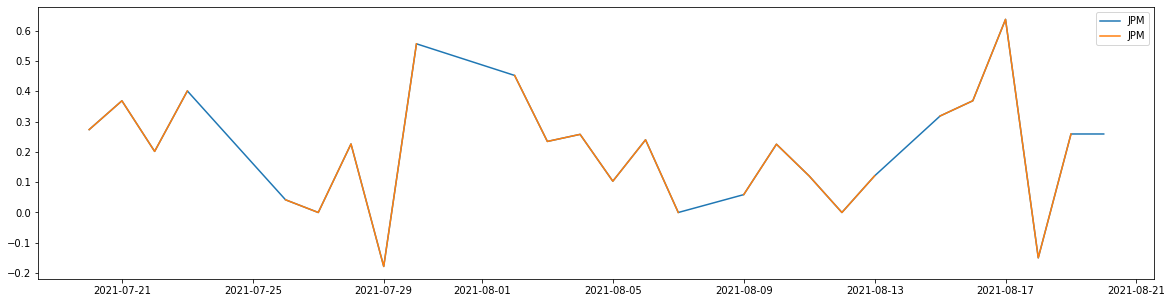

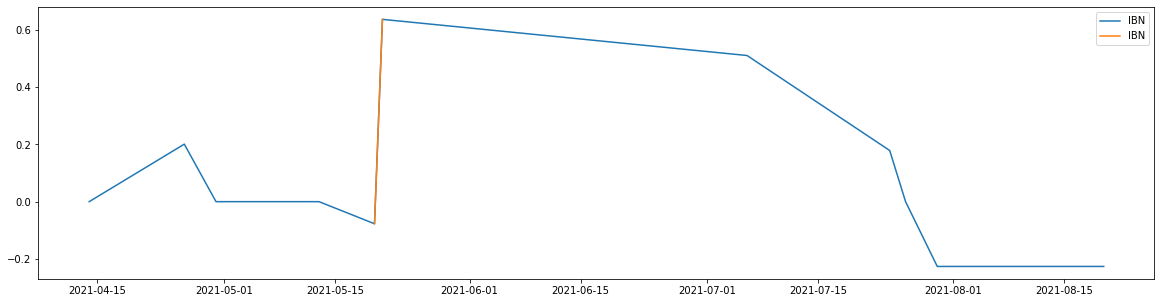

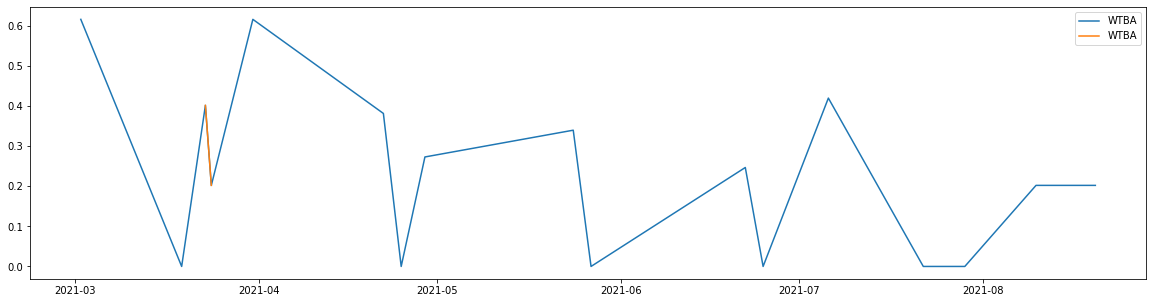

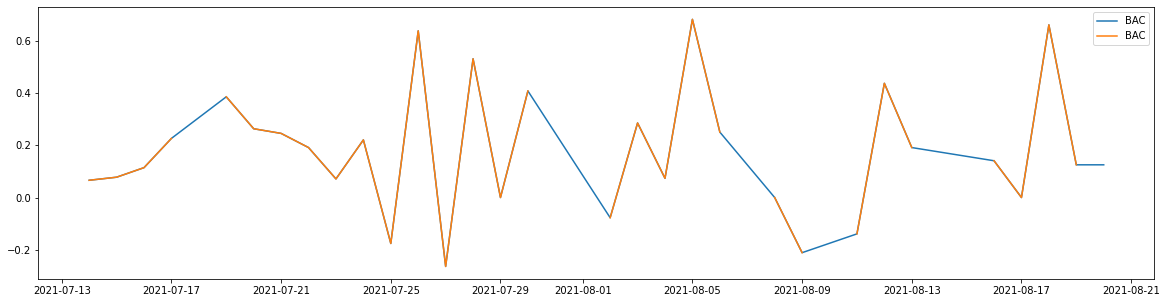

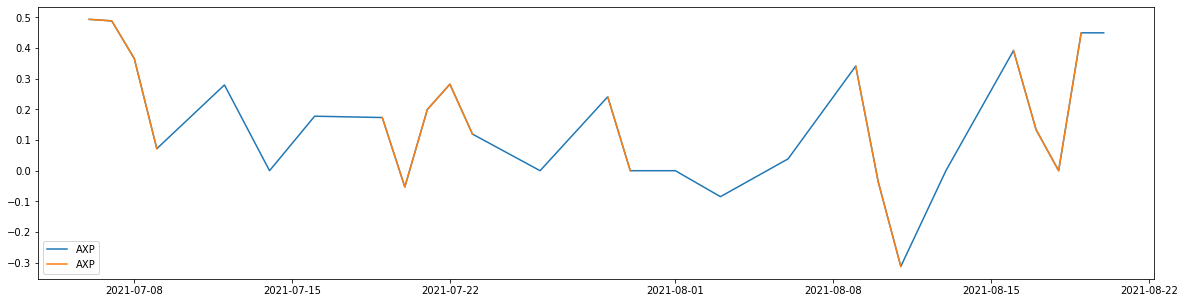

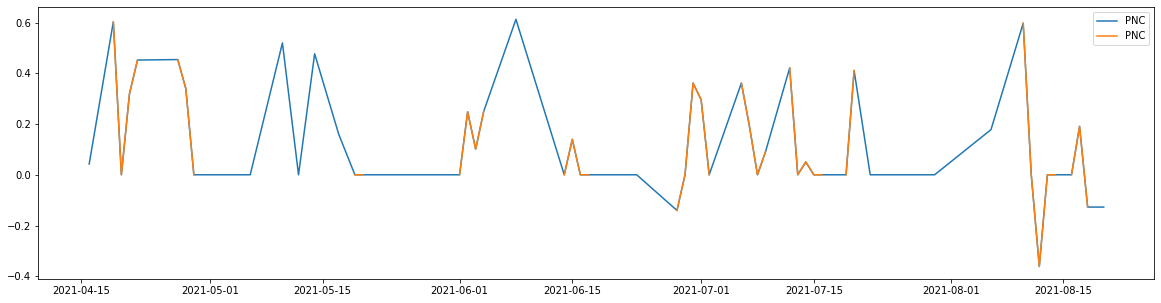

BNS      RY      TD  BMO       CM         C      JPM  IBN  \
2021-03-01  0.179700 -0.2263  0.4754  0.0  0.64775  0.208618  0.27334  0.0   
2021-03-02  0.595050 -0.2263  0.4754  0.0  0.64775  0.208618  0.27334  0.0   
2021-03-03  0.548925 -0.2263  0.4754  0.0  0.64775  0.208618  0.27334  0.0   
2021-03-04  0.502800 -0.2263  0.4754  0.0  0.64775  0.208618  0.27334  0.0   
2021-03-05  0.000000 -0.2263  0.4754  0.0  0.64775  0.208618  0.27334  0.0   

                WTBA      BAC     AXP       PNC  
2021-03-01  0.616600  0.06595  0.4939  0.042286  
2021-03-02  0.616600  0.06595  0.4939  0.042286  
2021-03-03  0.580329  0.06595  0.4939  0.042286  
2021-03-04  0.544059  0.06595  0.4939  0.042286  
2021-03-05  0.507788  0.06595  0.4939  0.042286

In [155]:
march_f=main_f[796:]
for i in march_f.columns:
    plt.plot(march_f[i].interpolate(),label=i)
    plt.plot(march_f[i],label=i)
    plt.legend()
    plt.show()
for i in march_f.columns:
    march_f[i]=march_f[i].interpolate()
    march_f[i]=march_f[i].bfill()
march_f.head()

## Now we define the functions to perform the forecasting

In [157]:
lag = 25
steps_ahead = 5
#n_features = 6
test_len=20

# Function to get the price data for all the banks
def get_data(ticker):
    df = DataReader(ticker, data_source='yahoo', start='2021-03-01', end=datetime.now())
    return df

# Function to convert a time series into sliding windows
def series_to_supervised_dl(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# Function to perform preprocessing and converting the input time series to input features and labels
def preprocess_dl(lag,steps_ahead,dff):
    senti=dff.iloc[:,-1:]
    df=dff.iloc[:,:1]
    scaler = MinMaxScaler(feature_range=(0,1))
    df = scaler.fit_transform(df)
    y_train=df[lag+steps_ahead-1:]
    df=pd.DataFrame(df)
    df.index=senti.index
    df["Senti"]=senti
    x=series_to_supervised_dl(df,lag-1)
    x_train=x[:len(y_train)].values
    x_input=x[-steps_ahead:].values
    x_train = x_train.reshape((x_train.shape[0], int(x_train.shape[1]/2), 2))
    x_input = x_input.reshape((x_input.shape[0], int(x_input.shape[1]/2), 2))
    return x_train,x_input,y_train,scaler

# Defining simple deep learning model with GRU
def model(lag):
    os.environ['PYTHONHASHSEED'] = '42'
    np.random.seed(42)
    np.random.RandomState(42)
    random.seed(42)
    
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape= (lag, 2)))
    model.add(GRU(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    return model


# Function to perform the training and saving the best weights in the path passed.
def train_univariate(model,x_train,y_train,path):
    reduce_lr = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
    checkpoint1 = keras.callbacks.ModelCheckpoint(path,
                                                     monitor='val_loss',
                                                     save_best_only=True,
                                                     mode='min')
    es=keras.callbacks.EarlyStopping(patience=10)


    model.compile(optimizer='adam', loss='mean_squared_error')
    history=model.fit(x_train,y_train,epochs=50,validation_split=0.25,verbose=0,batch_size=32,callbacks=[reduce_lr,checkpoint1,es])
    plt.figure()
    plt.plot(np.arange(len(history.history['loss'])), history.history['loss'],color='r', label='Training loss')

    plt.plot(np.arange(len(history.history['loss'])),history.history['val_loss'],color='b', label='Validation loss')
    plt.title('Training vs Validation Loss (MAE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Function to find the forecasts and perform inverse transform    
def predict_dl(model,path,x_input,scaler):
    model.load_weights(path)
    predictions = model.predict(x_input)
    predictions = scaler.inverse_transform(predictions)
    return predictions
 


## In the snippet below for every bank the simple DL model is trained using the sentiment score from the news and closing prices of the bank from the past 25 days.  

## The training is done in such a way that the past 25 inputs are mapped to the labels 5 days ahead. So we can just use the past 25 values of sentiments and closing prices to forecats the closing price of future Thursday 26th August.

For, BNS


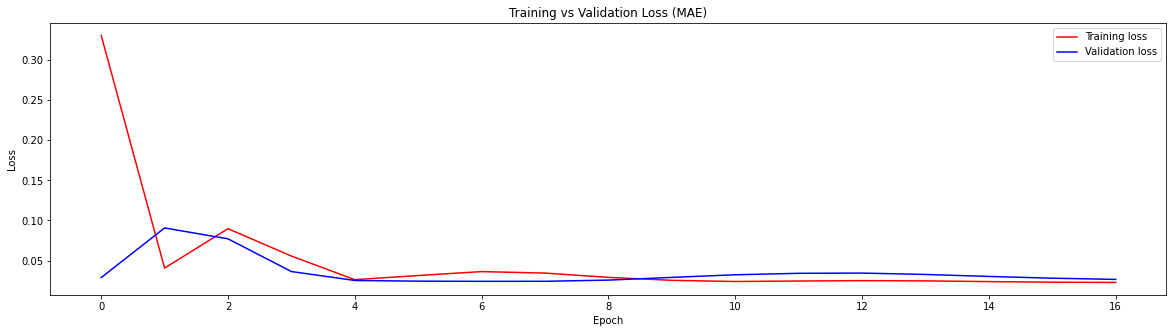

Forecast for the next Thursday is  63.202347
For, RY


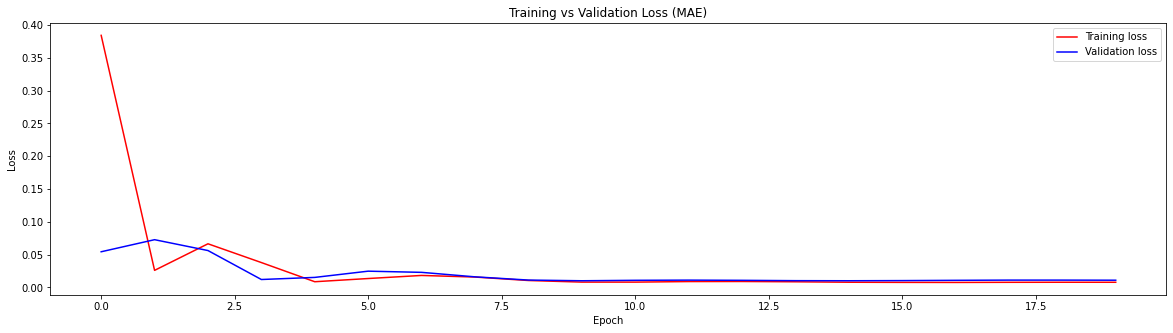

Forecast for the next Thursday is  103.8582
For, TD


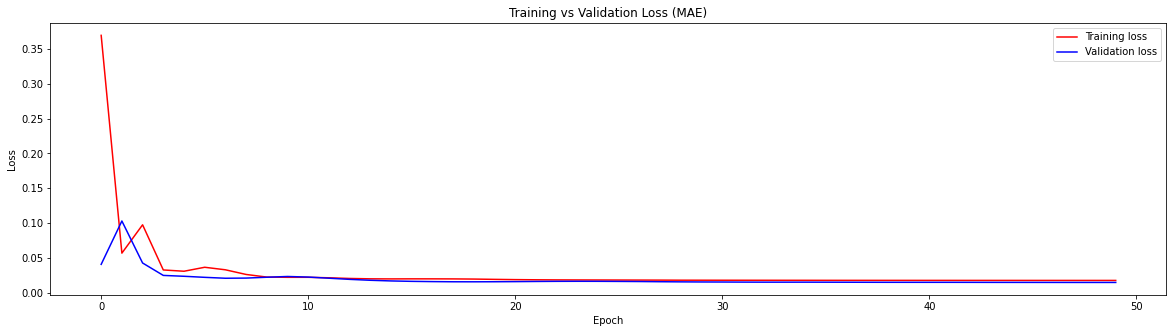

Forecast for the next Thursday is  68.28595
For, BMO


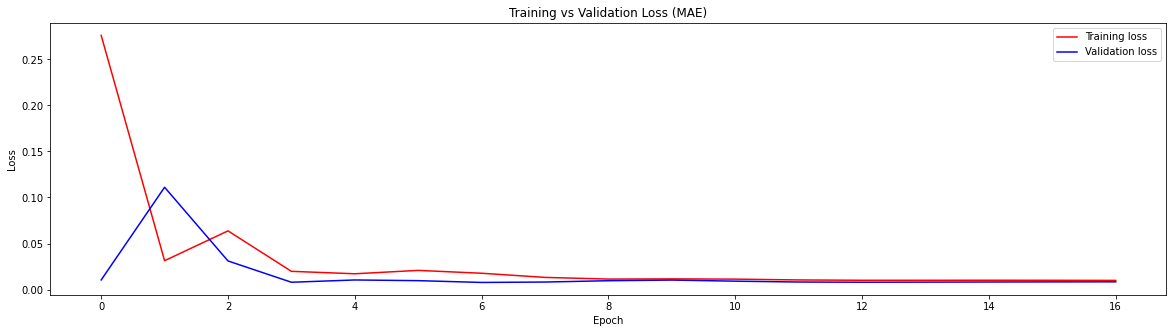

Forecast for the next Thursday is  101.03904
For, CM


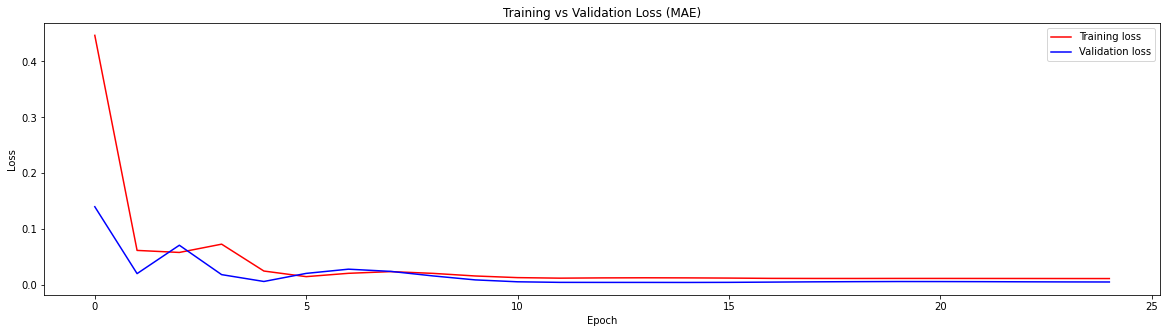

Forecast for the next Thursday is  118.11316
For, C


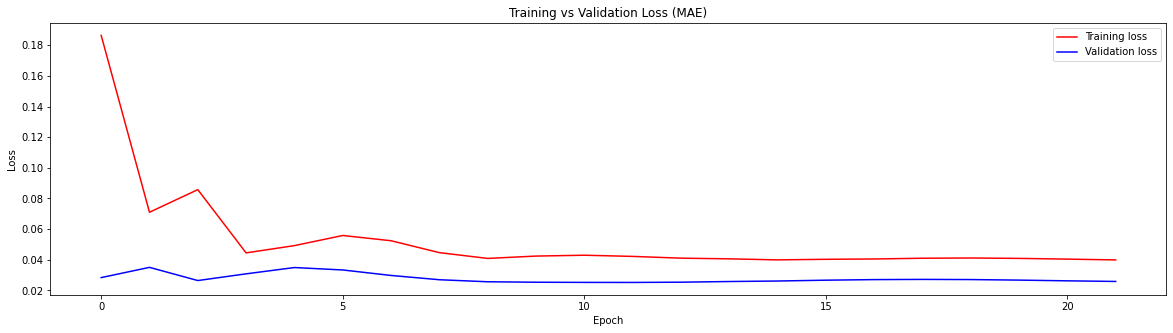

Forecast for the next Thursday is  71.9641
For, JPM


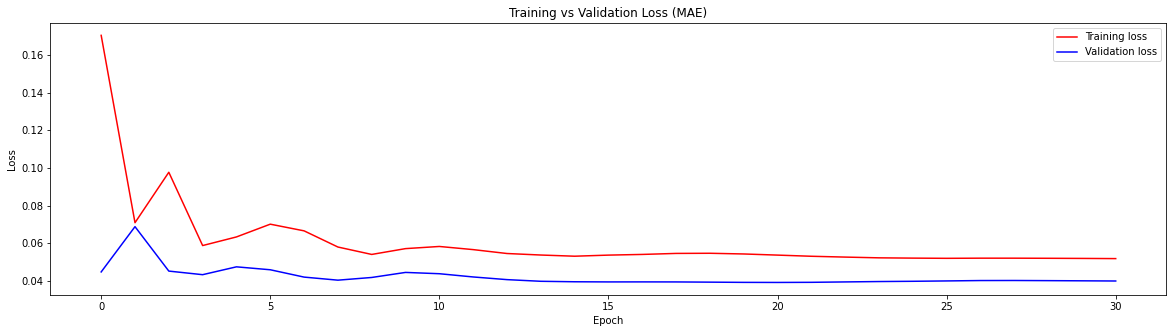

Forecast for the next Thursday is  155.49037
For, IBN


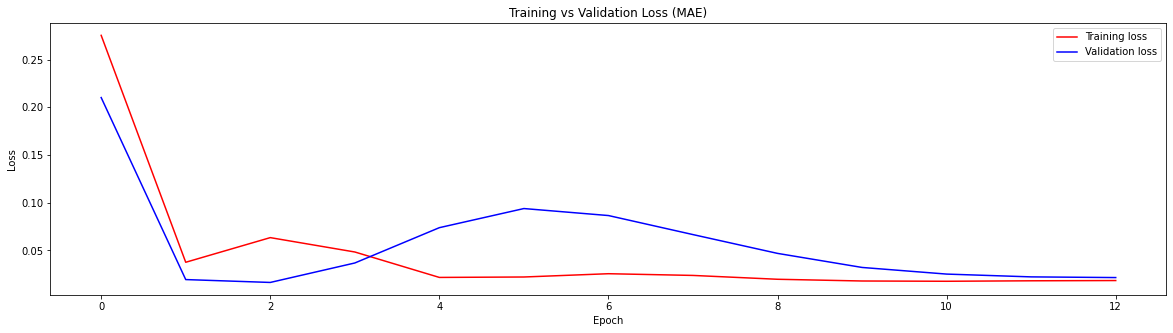

Forecast for the next Thursday is  18.56581
For, WTBA


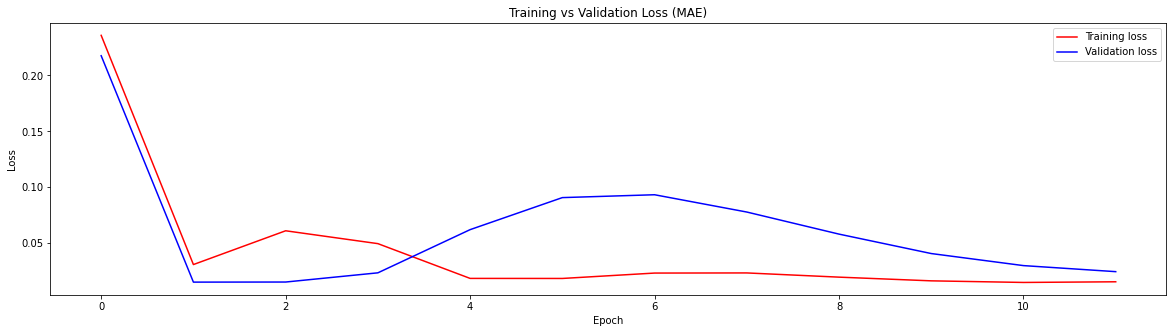

Forecast for the next Thursday is  31.57684
For, BAC


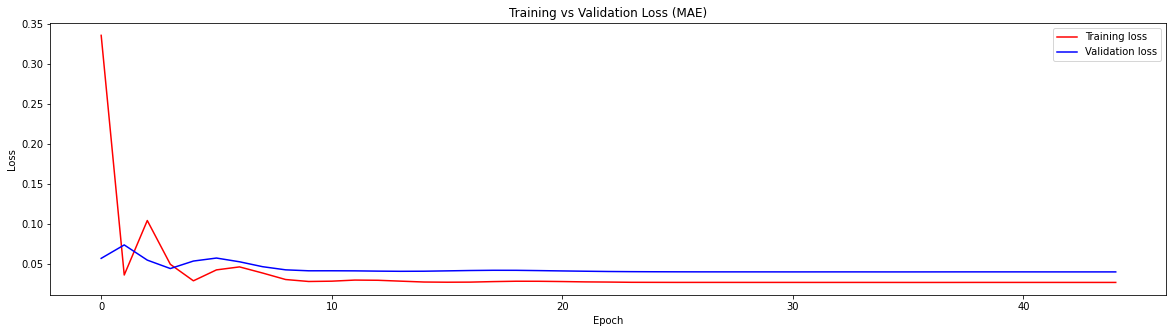

Forecast for the next Thursday is  40.892242
For, AXP


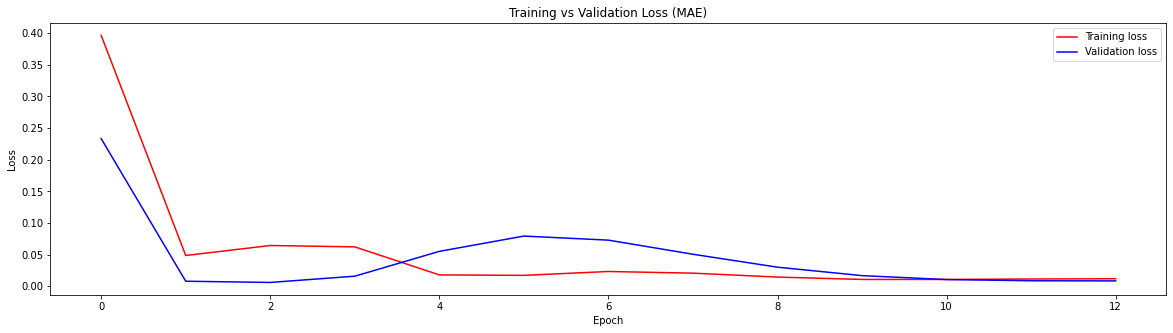

Forecast for the next Thursday is  166.5082
For, PNC


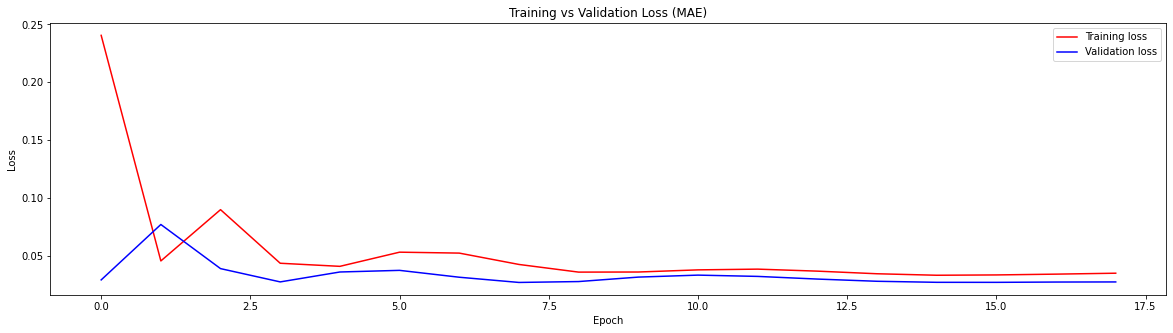

Forecast for the next Thursday is  186.27907


In [158]:
out_sent=[]
for i in tickers:
    print("For,", i)
    df=get_data(i)
    df = df.filter(['Close'])
    dff=pd.concat([df,march_f[i]],axis=1).dropna()
    x_train,x_input,y_train,scaler=preprocess_dl(lag,steps_ahead,dff)
    path=i+"weights.hdf5"
    model1=model(lag)
    train_univariate(model1,x_train,y_train,path)
    predictions=predict_dl(model1,path,x_input,scaler)
    out_sent.append(predictions)
    print("Forecast for the next Thursday is ",predictions[-1:][0][0])

## The output for the 5 days ahead forecast from the model using sentiments from news is as follows:

In [159]:
out_sent=np.asarray(out_sent)
SP=pd.DataFrame(out_sent.reshape(12,5),index=tickers,columns=r).T
SP

BNS          RY         TD         BMO          CM  \
2021-08-20  63.435360  104.303154  68.787064  101.286041  119.013908   
2021-08-23  63.488190  104.486153  68.828789  101.560860  119.171768   
2021-08-24  63.438808  104.429146  68.767166  101.614578  119.002594   
2021-08-25  63.366852  104.282578  68.634247  101.491936  118.775414   
2021-08-26  63.202347  103.858200  68.285950  101.039040  118.113159   

                    C         JPM        IBN       WTBA        BAC  \
2021-08-20  72.868927  156.673111  18.715258  31.658808  41.205666   
2021-08-23  72.831093  156.725235  18.734556  31.783037  41.245491   
2021-08-24  72.820480  157.015198  18.713188  31.805069  41.194912   
2021-08-25  72.446907  156.233292  18.648113  31.714615  41.077126   
2021-08-26  71.964104  155.490372  18.565809  31.576839  40.892242   

                   AXP         PNC  
2021-08-20  165.392487  190.189102  
2021-08-23  166.169708  189.487549  
2021-08-24  166.677353  188.553955  
2021-08-25  166.207184  187.477066  
2021-08-26  166.508194  186.279068

<a id="vr"><a>

# Results:
    
## Voting Regressor Ensemble 


## The final output for Thursday 26th August 2021 is derived by taking the weighted Voting regressor Ensemble of all the model outputs for 26th August. 

## For this a weight is assigned to every model's output on the basis of the Mean Absolute Percentage error obtained for all the models as discussed in the other python notebook.


## The MAPE obtained for all the models across all banks is pasted below from other python notebooks

In [192]:
stat2=[1.44775,1.158005,1.090842,1.350442,1.282904,2.834715,2.227976,2.244519,2.861901,2.821382,2.945433,2.856769]
DL1=[2.196709,2.298721,2.406785, 2.806831, 2.844227,4.059731,2.787255,3.103551,3.620858,4.004264,3.202899,3.64671]
stat1= [1.475972,1.264431,1.168521,1.259598,1.148736,2.671106,1.895053,2.054463,2.846624,2.617496,2.632643,2.486249]
DL2=[1.95486,1.945835,1.716269,1.593851,2.228083,4.200878,2.135438,5.024772,4.717863,3.907899,3.657247,2.16089]
MAPE=pd.DataFrame(stat1,columns=["stat1"])
MAPE["stat2"]=stat2
MAPE["DL1"]=DL1
MAPE["DL2"]=DL2
MAPE.index=tickers
MAPE

stat1     stat2       DL1       DL2
BNS   1.475972  1.447750  2.196709  1.954860
RY    1.264431  1.158005  2.298721  1.945835
TD    1.168521  1.090842  2.406785  1.716269
BMO   1.259598  1.350442  2.806831  1.593851
CM    1.148736  1.282904  2.844227  2.228083
C     2.671106  2.834715  4.059731  4.200878
JPM   1.895053  2.227976  2.787255  2.135438
IBN   2.054463  2.244519  3.103551  5.024772
WTBA  2.846624  2.861901  3.620858  4.717863
BAC   2.617496  2.821382  4.004264  3.907899
AXP   2.632643  2.945433  3.202899  3.657247
PNC   2.486249  2.856769  3.646710  2.160890

## The avg. MAPE for both the statistical methods is around 2% and both the DL methods 3% as we can see clearly from below. 

## Thus, we can say that the DL methods give us 50% more error percentage than the statistical methods.

### On testing all the four models it is found that the error of the DL models is 50% more than the statistical models, clearly the statistical approach outperforms the DL method and hence the weights assigned to the model output from statistical approach is twice the weights assigned to DL models.

In [193]:
MAPE.mean()

stat1    1.960074
stat2    2.093553
DL1      3.081545
DL2      2.936990
dtype: float64

## Therefore, the weights assigned to the DL methods is half of the weight assigned to the statistical methods. The statistical methods are assigned weight of 2 and the DL methods are assigned weight of 1.

## Below the weighted ensembling or weighted average is performed on the outputs of all the models and final forecast for five days ahead is obtained.

In [195]:
result=(2*STAT + DL + 2*output + SP)/ 6
result

BNS          RY         TD        BMO          CM  \
2021-08-20  62.609893  102.588938  67.407427  99.703406  115.616739   
2021-08-23  62.574491  102.432222  67.394280  99.628639  115.604198   
2021-08-24  62.390877  102.365332  67.349991  99.393687  115.205171   
2021-08-25  62.239143  102.161085  67.171578  99.192514  115.077613   
2021-08-26  61.982034  101.886087  66.937311  98.784661  114.585033   

                    C         JPM        IBN       WTBA        BAC  \
2021-08-20  71.100211  155.335116  18.727834  30.353102  40.588767   
2021-08-23  70.808127  155.008918  18.692075  30.368269  40.530435   
2021-08-24  70.694014  154.966760  18.658315  30.371403  40.485382   
2021-08-25  70.608585  154.682394  18.606350  30.275395  40.471586   
2021-08-26  70.372845  154.037663  18.573442  30.156733  40.315136   

                   AXP         PNC  
2021-08-20  162.246109  186.758677  
2021-08-23  161.382112  186.355216  
2021-08-24  161.524950  186.100306  
2021-08-25  161.229393  185.357904  
2021-08-26  161.040661  184.361190

## The stock closing values for current Thursday (19th August) are given below

In [196]:
thurs_current

BNS          RY         TD        BMO     CM          C  \
Date                                                                        
2021-08-19  62.040001  101.610001  66.720001  98.860001  114.5  69.839996   

                   JPM        IBN       WTBA        BAC         AXP  \
Date                                                                  
2021-08-19  154.279999  18.549999  29.889999  40.189999  159.029999   

                   PNC  
Date                    
2021-08-19  184.339996

## The stock closing values obtained for next Thursday (26th August) are given below

In [197]:
result[-1:]

BNS          RY         TD        BMO          CM  \
2021-08-26  61.982034  101.886087  66.937311  98.784661  114.585033   

                    C         JPM        IBN       WTBA        BAC  \
2021-08-26  70.372845  154.037663  18.573442  30.156733  40.315136   

                   AXP        PNC  
2021-08-26  161.040661  184.36119

## Finding if the future closing stock value is more than the current stock value.

In [198]:
result[-1:].values>thurs_current.values

array([[False,  True,  True, False,  True,  True, False,  True,  True,
         True,  True,  True]])

## In order to pick the best 5 banks whose future Thursday price is likely to increase than the current one we analyse the avg. MAPE obtained across the banks using all the 4 methods. Finally the banks which have true as output and have relatively lower avg. MAPE are picked for final output result.

In [199]:
MAPE.T.mean()

BNS     1.768823
RY      1.666748
TD      1.595604
BMO     1.752680
CM      1.875987
C       3.441607
JPM     2.261430
IBN     3.106826
WTBA    3.511812
BAC     3.337760
AXP     3.109555
PNC     2.787654
dtype: float64

# The final output suggests that the stock closing value for next Thursday,  26th August will be more than the current Thursday, 19th August values for following banks:
## 1. Royal Bank Canada
## 2. TD Bank
## 3. CIBC Bank
## 4. PNC financial services
## 5. American Express


# Conclusion and Inferences
### 1. The DL models have the ability to consider the additional explanatory variables to the model, like we can add the sentiments from the news for forecasting the stock price and this adds to some information to the model for better forecasting.
### 2. It is found that the although the statistical models cannot take other variables into consideration yet they outperform the DL models in terms on the lesser forecasting error which they provide. A possible reason of the statistical models outperforming the DL models might be that the data is not very complex and has finite sampling setting.

### 3. Also, this ensemble technique using different models helps in picking up the trends and learnings from one model which another model might have missed.

# Future work
### 1. A possible future work could be to form a generalised model for the stock price prediction for all the companies which can be just fine tuned on every company's data using transfer learning. This will save on the computational complexity incurred while training all the models from scratch for every stock.
### 2. We can also add few features for stock price prediction like the sentiments from the twitter and other factors like the stock fundamentals and stock security with proper regularization since, sometimes adding additional features causes overfitting and does not necessarily add to the model's accuracy


